In [8]:
import os
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import argparse

In [9]:
def create_manifest(tiles_basedir, sentences_basedir, output_dir, val_split=0.05):
    """
    Scans tile and sentence directories to create a CSV manifest for OpenClip training.

    Args:
        tiles_basedir (str): The root directory containing the sample tile folders (e.g., '.../TENX101_BN1_tiles').
        sentences_basedir (str): The root directory containing the sample sentence folders.
        output_dir (str): Directory where the manifest CSV files will be saved.
        val_split (float): The fraction of data to use for the validation set.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    manifest_data = []
    print("Scanning directories to build manifest...")

    # Assumes sentence directories match tile directories but with a different suffix
    sentence_dirs = [d for d in os.listdir(sentences_basedir) if d.endswith('_sentences_hvg')]

    for sent_dir_name in tqdm(sentence_dirs, desc="Processing Samples"):
        sample_id = sent_dir_name.replace('_sentences_hvg', '')
        
        # Construct corresponding tile directory name
        tile_dir_name = f"{sample_id}_tiles" # Or another suffix if it's different
        
        sent_dir_path = os.path.join(sentences_basedir, sent_dir_name)
        tile_dir_path = os.path.join(tiles_basedir, tile_dir_name)
        
        if not os.path.isdir(tile_dir_path):
            print(f"Warning: Tile directory not found for {sample_id}, skipping.")
            continue
            
        for sentence_file in os.listdir(sent_dir_path):
            if not sentence_file.endswith('.txt'):
                continue
            
            # Construct the corresponding image file name from the sentence file name
            # e.g., 'TENX101_BN1_2544_13499.txt' -> 'TENX101_BN1_2544_13499.png'
            image_file = sentence_file.replace('.txt', '.png')
            image_path = os.path.join(tile_dir_path, image_file)
            
            # Check if both files actually exist before adding to the manifest
            if os.path.exists(image_path):
                # Read the gene sentence from the file
                with open(os.path.join(sent_dir_path, sentence_file), 'r') as f:
                    gene_sentence = f.read().strip()
                
                manifest_data.append({
                    'image_path': image_path,
                    'gene_sentence': gene_sentence
                })

    if not manifest_data:
        raise ValueError("No matching image-sentence pairs were found. Check your directory paths and file naming conventions.")

    # Convert to a DataFrame
    df = pd.DataFrame(manifest_data)
    print(f"Successfully found {len(df)} matching image-sentence pairs.")

    # Split into training and validation sets
    if val_split > 0:
        train_df, val_df = train_test_split(df, test_size=val_split, random_state=42)
        val_path = os.path.join(output_dir, 'validation_manifest.csv')
        val_df.to_csv(val_path, index=False, sep=',')
        print(f"Validation manifest saved to: {val_path} ({len(val_df)} samples)")
    else:
        train_df = df

    train_path = os.path.join(output_dir, 'train_manifest.csv')
    train_df.to_csv(train_path, index=False, sep=',')
    print(f"Training manifest saved to: {train_path} ({len(train_df)} samples)")

In [10]:
sentences_basedir = '/cwStorage/nodecw_group/jijh/hest_sentences'

In [11]:
tile_basedir = '/cwStorage/nodecw_group/jijh/hest_output'

In [12]:
output_dir = "/cwStorage/nodecw_group/jijh/openclip_train"

In [13]:
create_manifest(tiles_basedir=tile_basedir,
                sentences_basedir=sentences_basedir,
                output_dir=output_dir,
                val_split=0.05)

Scanning directories to build manifest...


Processing Samples:   0%|          | 0/168 [00:00<?, ?it/s]

Successfully found 307724 matching image-sentence pairs.
Validation manifest saved to: /cwStorage/nodecw_group/jijh/openclip_train/validation_manifest.csv (15387 samples)
Training manifest saved to: /cwStorage/nodecw_group/jijh/openclip_train/train_manifest.csv (292337 samples)


# Clip Train!

In [1]:
# ==============================================================================
#           Cell: OpenCLIP Fine-tuning Launcher (Robust Version) - CORRECTED
# ==============================================================================
import os
import sys
import subprocess
import shlex
import fcntl
import select
import datetime

# --- 1. Training Configuration ---
class OpenClipFinetuneConfig:
    # --- Hardware & Distributed Training ---
    GPU_IDS = [0, 1, 2]
    NUM_GPUS = len(GPU_IDS)
    DDP_MASTER_PORT = 29501

    # --- Paths (使用绝对路径) ---
    PROJECT_ROOT = "/cwStorage/nodecw_group/jijh/openclip_train"
    OPEN_CLIP_SRC_DIR = os.path.join(PROJECT_ROOT, "open_clip/src")
    TRAIN_MANIFEST = os.path.join(PROJECT_ROOT, "train_manifest.csv")
    VAL_MANIFEST = os.path.join(PROJECT_ROOT, "validation_manifest.csv")

    TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    LOGS_DIR = os.path.join(PROJECT_ROOT, "train_log", f"finetune_{TIMESTAMP}")

    PRETRAINED_MODEL_PATH = os.path.join(PROJECT_ROOT, "open_clip/CLIP-ViT-B-32/open_clip_model.safetensors")

    # --- Model & Data Hyperparameters ---
    MODEL_NAME = "ViT-B-32"
    DATASET_TYPE = "csv"
    CSV_SEPARATOR = ","
    CSV_IMG_KEY = "image_path"
    CSV_CAPTION_KEY = "gene_sentence"

    # --- Training Hyperparameters ---
    EPOCHS = 10
    BATCH_SIZE_PER_GPU = 512
    LEARNING_RATE = 5e-6
    WEIGHT_DECAY = 0.1
    WARMUP_STEPS = 500
    PRECISION = "amp_bfloat16" # For H100
    NUM_WORKERS = 8
    
    # ============================
    #      *** NEWLY ADDED ***
    # ============================
    # Standard context length for ViT-B-32 is 77. This is now required by the training script.
    FORCE_CONTEXT_LENGTH = 77

    # --- Logging & Saving ---
    REPORT_TO = "tensorboard"
    SAVE_FREQUENCY = 1
    LOG_EVERY_N_STEPS = 100

    @classmethod
    def build_command(cls):
        """
        构建一个更简洁、更具兼容性的torchrun命令。
        增加了缺失的 force_context_length 参数。
        """
        python_executable = sys.executable

        cmd = [
            python_executable, "-m", "torch.distributed.run",
            f"--nproc_per_node={cls.NUM_GPUS}",
            f"--master_port={cls.DDP_MASTER_PORT}",
            os.path.join(cls.OPEN_CLIP_SRC_DIR, "open_clip_train/main.py"),

            # 核心参数
            "--model", cls.MODEL_NAME,
            "--pretrained", cls.PRETRAINED_MODEL_PATH,
            "--train-data", cls.TRAIN_MANIFEST,
            "--val-data", cls.VAL_MANIFEST,
            "--dataset-type", cls.DATASET_TYPE,
            "--csv-separator", cls.CSV_SEPARATOR,
            "--csv-img-key", cls.CSV_IMG_KEY,
            "--csv-caption-key", cls.CSV_CAPTION_KEY,
            "--logs", cls.LOGS_DIR,

            # 训练超参数
            "--epochs", str(cls.EPOCHS),
            "--batch-size", str(cls.BATCH_SIZE_PER_GPU),
            "--lr", str(cls.LEARNING_RATE),
            "--wd", str(cls.WEIGHT_DECAY),
            "--warmup", str(cls.WARMUP_STEPS),
            "--precision", cls.PRECISION,
            
            # ============================
            #      *** NEWLY ADDED ***
            # ============================
            # Add the force-context-length argument to the command
            "--force-context-length", str(cls.FORCE_CONTEXT_LENGTH),

            # 系统和日志参数
            "--workers", str(cls.NUM_WORKERS),
            "--report-to", cls.REPORT_TO,
            "--save-frequency", str(cls.SAVE_FREQUENCY),
            "--log-every-n-steps", str(cls.LOG_EVERY_N_STEPS),
        ]
        return cmd

In [2]:
# --- 2. 实例化配置并准备环境 ---
config = OpenClipFinetuneConfig()
os.makedirs(config.LOGS_DIR, exist_ok=True)
print(f"✅ 配置加载成功。日志和模型将保存到: {config.LOGS_DIR}")


✅ 配置加载成功。日志和模型将保存到: /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429


In [3]:
# --- 3. 检查关键文件和目录是否存在 ---
paths_to_check = {
    "训练脚本": os.path.join(config.OPEN_CLIP_SRC_DIR, "open_clip_train/main.py"),
    "训练清单文件": config.TRAIN_MANIFEST,
    "验证清单文件": config.VAL_MANIFEST,
    "预训练模型": config.PRETRAINED_MODEL_PATH,
}
all_paths_ok = True
for name, path in paths_to_check.items():
    if not os.path.exists(path):
        print(f"❌ 错误: {name} 未找到，路径: {path}")
        all_paths_ok = False

if all_paths_ok:
    print("✅ 所有关键文件和目录均已找到。")
    
    # --- 4. 构建并执行命令 ---
    command_list = config.build_command()
    
    execution_env = os.environ.copy()
    execution_env["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, config.GPU_IDS))
    
    print("\n" + "="*80)
    print("      即将执行以下精简命令:")
    print("="*80)
    print(shlex.join(command_list))
    print("="*80, "\n")
    
    # --- 实时流式输出的执行逻辑 ---
    try:
        # 注意: 这里不再需要 `cwd` 参数，因为主脚本路径已经是绝对路径
        process = subprocess.Popen(
            command_list,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            encoding='utf-8',
            errors='replace',
            env=execution_env,
            bufsize=1
        )

        fd = process.stdout.fileno()
        fl = fcntl.fcntl(fd, fcntl.F_GETFL)
        fcntl.fcntl(fd, fcntl.F_SETFL, fl | os.O_NONBLOCK)

        print("--- [ 训练开始，实时日志如下 ] ---\n")
        
        while True:
            if process.poll() is not None:
                break
            
            readable, _, _ = select.select([process.stdout], [], [], 0.1)
            
            if process.stdout in readable:
                try:
                    line = process.stdout.read()
                    if line:
                        sys.stdout.write(line)
                        sys.stdout.flush()
                except (TypeError, ValueError):
                    break
        
        remaining_output, _ = process.communicate()
        if remaining_output:
            print(remaining_output.strip())

        exit_code = process.returncode
        print(f"\n--- [ 训练结束，退出码: {exit_code} ] ---")
        if exit_code == 0:
            print("✅ 微调任务成功完成！")
        else:
            print("❌ 微调任务失败。请检查上面的日志输出以获取详细错误信息。")

    except Exception as e:
        print(f"❌ 执行过程中发生意外错误: {e}")

else:
    print("\n请修正上述路径错误后再运行此单元格。")

✅ 所有关键文件和目录均已找到。

      即将执行以下精简命令:
/public/home/jijh/micromamba/envs/gigapath/bin/python -m torch.distributed.run --nproc_per_node=3 --master_port=29501 /cwStorage/nodecw_group/jijh/openclip_train/open_clip/src/open_clip_train/main.py --model ViT-B-32 --pretrained /cwStorage/nodecw_group/jijh/openclip_train/open_clip/CLIP-ViT-B-32/open_clip_model.safetensors --train-data /cwStorage/nodecw_group/jijh/openclip_train/train_manifest.csv --val-data /cwStorage/nodecw_group/jijh/openclip_train/validation_manifest.csv --dataset-type csv --csv-separator , --csv-img-key image_path --csv-caption-key gene_sentence --logs /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429 --epochs 10 --batch-size 512 --lr 5e-06 --wd 0.1 --warmup 500 --precision amp_bfloat16 --force-context-length 77 --workers 8 --report-to tensorboard --save-frequency 1 --log-every-n-steps 100

--- [ 训练开始，实时日志如下 ] ---


*****************************************
Setting OMP_NUM_THREADS environment variab

## 继续微调

In [ ]:
# ==============================================================================
#           Cell: OpenCLIP Fine-tuning Launcher (with Resume Logic)
# ==============================================================================
import os
import sys
import subprocess
import shlex
import fcntl
import select
import datetime

# --- 1. Training Configuration ---
class OpenClipFinetuneConfig:
    # --- Hardware & Distributed Training ---
    GPU_IDS = [0, 1, 2]
    NUM_GPUS = len(GPU_IDS)
    DDP_MASTER_PORT = 29501 

    # --- Paths ---
    PROJECT_ROOT = "/cwStorage/nodecw_group/jijh/openclip_train"
    OPEN_CLIP_SRC_DIR = os.path.join(PROJECT_ROOT, "open_clip/src")
    TRAIN_MANIFEST = os.path.join(PROJECT_ROOT, "train_manifest.csv")
    VAL_MANIFEST = os.path.join(PROJECT_ROOT, "validation_manifest.csv")
    
    # [修改点 1] 指向您之前训练的日志目录，而不是创建一个新的
    # 您需要从之前的日志输出中找到这个确切的目录名
    LOGS_DIR = os.path.join(PROJECT_ROOT, "train_log/finetune_20250620-204429")
    
    # [修改点 2] 定义要恢复的检查点路径
    # 使用 'epoch_latest.pt' 是最安全的选择
    RESUME_CHECKPOINT_PATH = os.path.join(
        LOGS_DIR, 
        "2025_06_20-20_44_44-model_ViT-B-32-lr_5e-06-b_512-j_8-p_amp_bfloat16/checkpoints/epoch_10.pt"
    )
    
    # 预训练模型路径现在不再需要，因为所有信息都在检查点里
    # PRETRAINED_MODEL_PATH = ...

    # --- Model & Data ---
    MODEL_NAME = "ViT-B-32"
    # ... 其他数据参数保持不变 ...
    CSV_IMG_KEY = "image_path"
    CSV_CAPTION_KEY = "gene_sentence"

    # --- Training Hyperparameters ---
    # [修改点 3] 增加总的epochs数量，例如，再训练10个epoch
    TOTAL_EPOCHS = 20  # 原来训练了10个，现在总共训练到20个
    
    # [修改点 4] 恢复训练时，通常使用一个更小的学习率
    LEARNING_RATE = 1e-6 # 从 5e-6 降低到 1e-6 进行更精细的微调
    
    BATCH_SIZE_PER_GPU = 128
    WEIGHT_DECAY = 0.1
    WARMUP_STEPS = 500 # 对于恢复训练，可以将warmup设为0，或者保持不变
    PRECISION = "amp_bfloat16"
    NUM_WORKERS = 8

    # --- Logging & Saving ---
    REPORT_TO = "tensorboard"
    SAVE_FREQUENCY = 10
    LOG_EVERY_N_STEPS = 100

    @classmethod
    def build_command(cls):
        """动态构建torchrun命令列表，现在加入了--resume参数"""
        python_executable = sys.executable
        
        cmd = [
            python_executable, "-m", "torch.distributed.run",
            f"--nproc_per_node={cls.NUM_GPUS}",
            f"--master_port={cls.DDP_MASTER_PORT}",
            os.path.join(cls.OPEN_CLIP_SRC_DIR, "open_clip_train/main.py"),
            
            # [修改点 5] 加入 --resume 参数
            "--resume", cls.RESUME_CHECKPOINT_PATH,
            
            # 模型和数据参数 (注意：--model 仍然需要，但 --pretrained 不再需要)
            "--model", cls.MODEL_NAME,
            "--train-data", cls.TRAIN_MANIFEST,
            "--val-data", cls.VAL_MANIFEST,
            "--dataset-type", "csv",
            "--csv-separator", ",",
            "--csv-img-key", cls.CSV_IMG_KEY,
            "--csv-caption-key", cls.CSV_CAPTION_KEY,
            
            # 日志目录
            "--logs", cls.LOGS_DIR,
            
            # 训练超参数
            "--epochs", str(cls.TOTAL_EPOCHS), # 传递总的epoch数
            "--batch-size", str(cls.BATCH_SIZE_PER_GPU),
            "--lr", str(cls.LEARNING_RATE),
            "--wd", str(cls.WEIGHT_DECAY),
            "--warmup", str(cls.WARMUP_STEPS),
            "--precision", cls.PRECISION,
            
            # 系统和日志参数
            "--workers", str(cls.NUM_WORKERS),
            "--report-to", cls.REPORT_TO,
            "--save-frequency", str(cls.SAVE_FREQUENCY),
            "--log-every-n-steps", str(cls.LOG_EVERY_N_STEPS),
        ]
        return cmd

# --- 实例化配置并执行 ---
config = OpenClipFinetuneConfig()
# 日志目录现在应该已经存在了，所以不需要再创建
# os.makedirs(config.LOGS_DIR, exist_ok=True) 

# --- 检查关键文件 ---
# 现在最关键的是检查检查点文件是否存在
if os.path.exists(config.RESUME_CHECKPOINT_PATH):
    print(f"✅ 找到要恢复的检查点文件: {config.RESUME_CHECKPOINT_PATH}")
    
    # ... (后面接上与之前相同的启动和实时输出代码) ...
    command_list = config.build_command()
    execution_env = os.environ.copy()
    execution_env["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, config.GPU_IDS))

    print("\n" + "="*80)
    print("      即将从检查点恢复训练:")
    print("="*80)
    print(shlex.join(command_list))
    print("="*80, "\n")

    # 执行并实时输出... (代码与上一回答中的相同)
    try:
        process = subprocess.Popen(
            command_list,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            encoding='utf-8',
            errors='replace',
            env=execution_env,
            cwd=config.OPEN_CLIP_SRC_DIR,
            bufsize=1
        )
        # ... (非阻塞读取循环) ...
        # ... (与上一回答中的代码完全相同) ...
        # 设置为非阻塞读取
        fd = process.stdout.fileno()
        fl = fcntl.fcntl(fd, fcntl.F_GETFL)
        fcntl.fcntl(fd, fcntl.F_SETFL, fl | os.O_NONBLOCK)

        print("--- [ 恢复训练开始，实时日志如下 ] ---\n")
        
        while True:
            if process.poll() is not None: break
            readable, _, _ = select.select([process.stdout], [], [], 0.1)
            if process.stdout in readable:
                try:
                    line = process.stdout.read()
                    if line:
                        sys.stdout.write(line)
                        sys.stdout.flush()
                except (TypeError, ValueError):
                    break
        
        remaining_output, _ = process.communicate()
        if remaining_output: print(remaining_output.strip())

        exit_code = process.returncode
        print(f"\n--- [ 训练结束，退出码: {exit_code} ] ---")
        if exit_code == 0:
            print("✅ 恢复训练任务成功完成！")
        else:
            print("❌ 恢复训练任务失败。")

    except Exception as e:
        print(f"❌ 执行过程中发生意外错误: {e}")

else:
    print(f"❌ 错误: 检查点文件未找到！路径: {config.RESUME_CHECKPOINT_PATH}")
    print("   请确认路径是否正确，或者您是否想要从头开始训练。")

✅ 找到要恢复的检查点文件: /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429/2025_06_20-20_44_44-model_ViT-B-32-lr_5e-06-b_512-j_8-p_amp_bfloat16/checkpoints/epoch_10.pt

      即将从检查点恢复训练:
/public/home/jijh/micromamba/envs/gigapath/bin/python -m torch.distributed.run --nproc_per_node=3 --master_port=29501 /cwStorage/nodecw_group/jijh/openclip_train/open_clip/src/open_clip_train/main.py --resume /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429/2025_06_20-20_44_44-model_ViT-B-32-lr_5e-06-b_512-j_8-p_amp_bfloat16/checkpoints/epoch_10.pt --model ViT-B-32 --train-data /cwStorage/nodecw_group/jijh/openclip_train/train_manifest.csv --val-data /cwStorage/nodecw_group/jijh/openclip_train/validation_manifest.csv --dataset-type csv --csv-separator , --csv-img-key image_path --csv-caption-key gene_sentence --logs /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429 --epochs 20 --batch-size 128 --lr 1e-06 --wd 0.1 --warmup 500

# Validation

/tmp/ipykernel_116642/1709233668.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


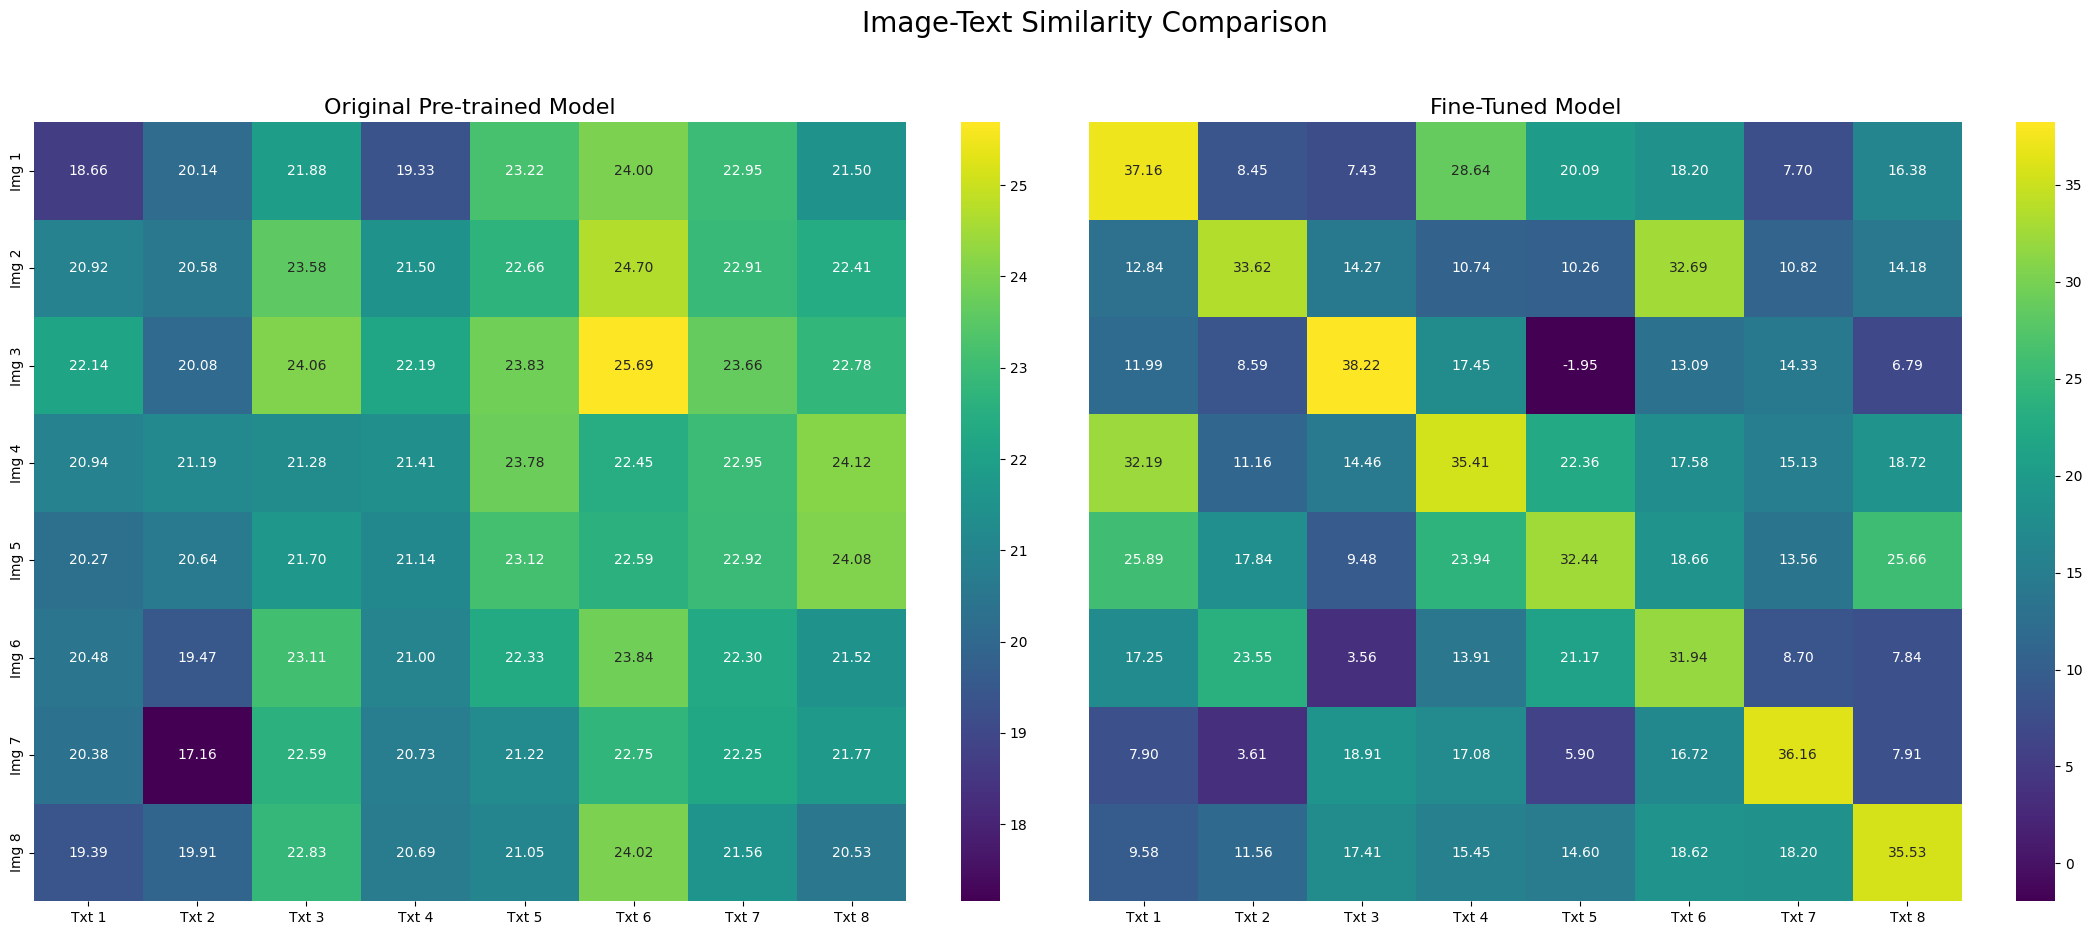

/tmp/ipykernel_116642/1709233668.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/tmp/ipykernel_116642/1709233668.py:267: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_116642/1709233668.py:267: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/public/home/jijh/micromamba/envs/gigapath/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/public/home/jijh/micromamba/envs/gigapath/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


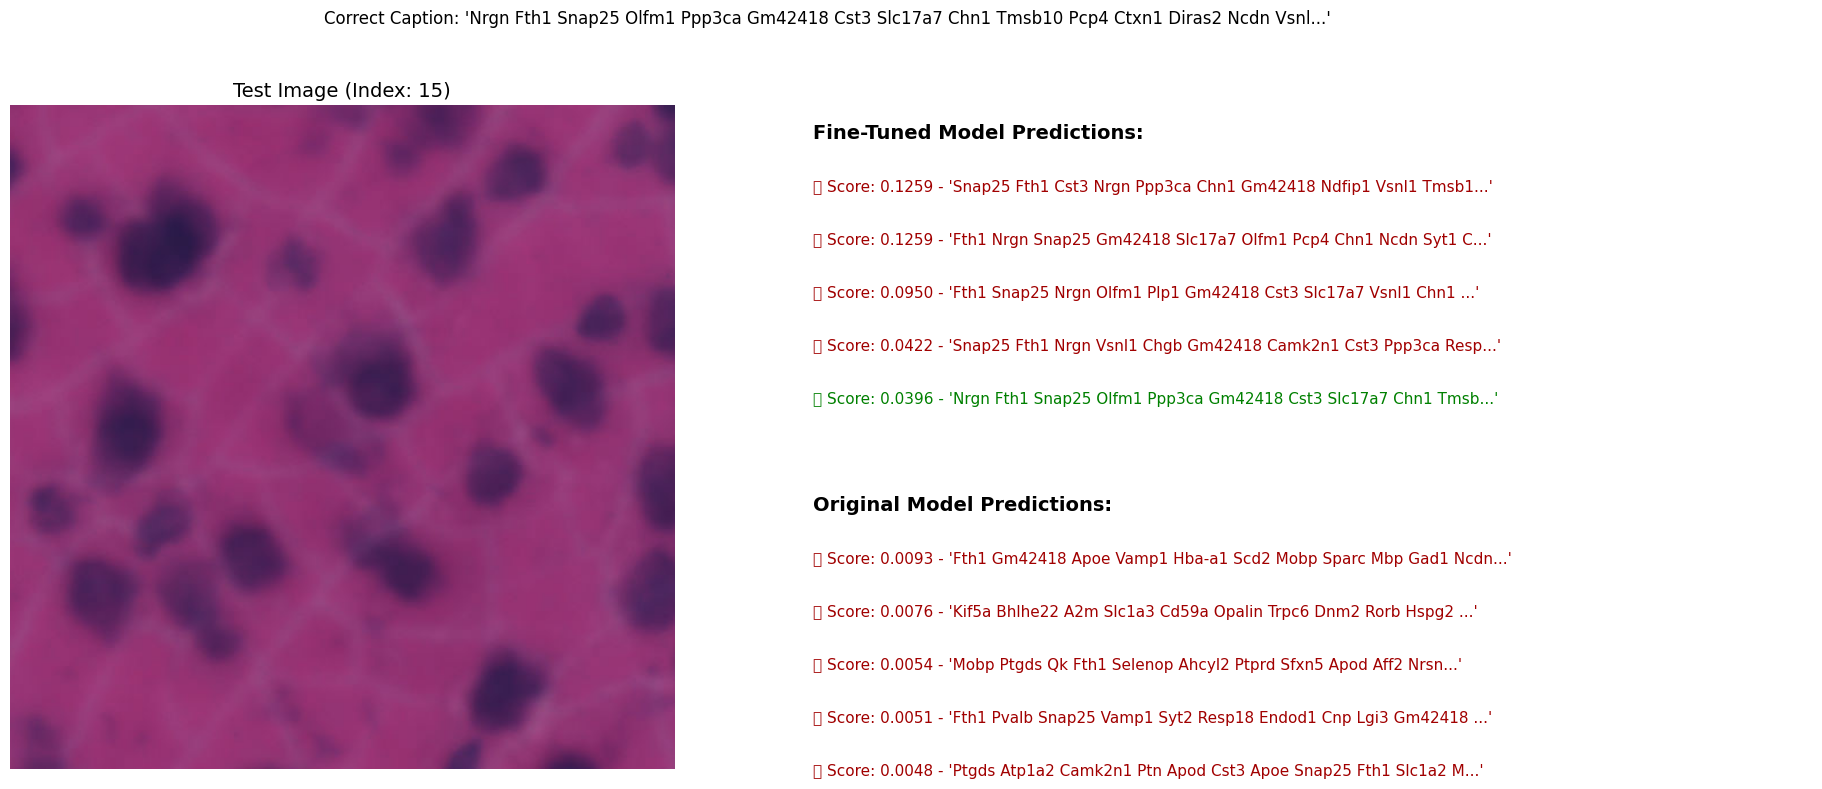

In [17]:
# ==============================================================================
# Full Modified Visualization Script
# ==============================================================================
import os
import sys
import logging
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import open_clip
from collections import OrderedDict

# Attempt to import safetensors
try:
    from safetensors.torch import load_file as load_safetensors
except ImportError:
    print("Error: The 'safetensors' library is not installed. Please install it with 'pip install safetensors'")
    sys.exit(1)

# ==============================================================================
# 1. CONFIGURATION: EDIT THIS SECTION
# ==============================================================================
class VisualizationConfig:
    """A central place for all your paths and settings for the visualization."""
    # --- Paths ---
    PROJECT_ROOT = "/cwStorage/nodecw_group/jijh/openclip_train"

    # Path to the validation manifest CSV
    VAL_MANIFEST = os.path.join(PROJECT_ROOT, "validation_manifest.csv")

    # Path to the ORIGINAL pre-trained model you started with
    PRETRAINED_MODEL_PATH = os.path.join(PROJECT_ROOT, "open_clip/CLIP-ViT-B-32/open_clip_model.safetensors")

    # Path to your FINAL, fine-tuned checkpoint.
    # IMPORTANT: Update this to point to the checkpoint you want to evaluate.
    FINETUNED_CHECKPOINT_PATH = os.path.join(
        PROJECT_ROOT,
        "train_log/finetune_20250620-204429", # Replace with your actual log directory
        "2025_06_20-20_44_44-model_ViT-B-32-lr_5e-06-b_512-j_8-p_amp_bfloat16/checkpoints/epoch_10.pt"
    )

    # --- Model & Device ---
    MODEL_NAME = "ViT-B-32"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # --- Visualization Sample Sizes ---
    HEATMAP_SAMPLE_SIZE = 8
    QUALITATIVE_SAMPLE_IDX = 15

# ==============================================================================
# 2. VISUALIZATION CLASS: MODIFICATIONS APPLIED
# ==============================================================================
class ClipVisualizer:
    """
    A class to visualize and compare the performance of a fine-tuned OpenCLIP model
    against its original pre-trained version.
    """
    def __init__(self, config: VisualizationConfig):
        """
        Initializes the visualizer by setting up logging, loading models, and data.
        """
        self.config = config
        self._setup_logging()

        logging.info("Initializing ClipVisualizer...")
        logging.info(f"Using device: {self.config.DEVICE.upper()}")

        self.original_model, self.img_processor, self.tokenizer = self._load_model(
            "Original Pre-trained", self.config.PRETRAINED_MODEL_PATH
        )
        self.finetuned_model, _, _ = self._load_model(
            "Fine-tuned", self.config.FINETUNED_CHECKPOINT_PATH
        )
        self.df_val = self._load_validation_data()

    def _setup_logging(self):
        """Configures the logging format and level."""
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s - [%(levelname)s] - %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S"
        )

    def _load_model(self, model_id: str, checkpoint_path: str):
        """
        Loads an OpenCLIP model and its preprocessors robustly from a local file.
        This version automatically handles checkpoints from DistributedDataParallel (DDP) training.
        """
        logging.info(f"Loading {model_id} model from: {checkpoint_path}")

        if not os.path.exists(checkpoint_path):
            logging.error(f"Checkpoint file not found at {checkpoint_path}")
            raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")

        model, _, image_processor = open_clip.create_model_and_transforms(
            self.config.MODEL_NAME,
            pretrained=None,
            device=self.config.DEVICE
        )
        tokenizer = open_clip.get_tokenizer(self.config.MODEL_NAME)

        if checkpoint_path.endswith(".safetensors"):
            state_dict = load_safetensors(checkpoint_path, device=self.config.DEVICE)
        else:
            state_dict = torch.load(checkpoint_path, map_location=self.config.DEVICE)

        if 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']

        if all(key.startswith('module.') for key in state_dict.keys()):
            logging.info("Detected 'module.' prefix from DDP training, stripping it from state_dict keys.")
            stripped_state_dict = OrderedDict()
            for key, value in state_dict.items():
                new_key = key.replace('module.', '', 1)
                stripped_state_dict[new_key] = value
            state_dict = stripped_state_dict

        try:
            model.load_state_dict(state_dict, strict=True)
            logging.info(f"{model_id} model loaded successfully.")
        except RuntimeError as e:
            logging.error(f"Failed to load state dict for {model_id}. Key mismatch error: {e}")
            raise

        model.eval()
        return model, image_processor, tokenizer

    def _load_validation_data(self):
        """Loads the validation manifest CSV into a pandas DataFrame."""
        logging.info(f"Loading validation data from: {self.config.VAL_MANIFEST}")
        try:
            df = pd.read_csv(self.config.VAL_MANIFEST)
            logging.info(f"Successfully loaded validation manifest with {len(df)} samples.")
            return df
        except FileNotFoundError:
            logging.error(f"Validation manifest not found at {self.config.VAL_MANIFEST}")
            raise

    def _get_similarity_matrix(self, model, image_paths: list, captions: list) -> np.ndarray:
        """
        Encodes a batch of images and texts and computes their cosine similarity matrix.
        """
        logging.info(f"Encoding {len(image_paths)} image/text pairs...")
        images = [self.img_processor(Image.open(p).convert("RGB")) for p in image_paths]
        image_tensor = torch.stack(images).to(self.config.DEVICE)
        text_tokens = self.tokenizer(captions).to(self.config.DEVICE)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image_tensor)
            text_features = model.encode_text(text_tokens)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            logging.info(f"Encoded image features shape: {image_features.shape}")
            logging.info(f"Encoded text features shape: {text_features.shape}")

            logit_scale = model.logit_scale.exp()
            similarity = (logit_scale * image_features @ text_features.T)

        return similarity.cpu().numpy()

    def plot_similarity_heatmap(self, sample_size: int = 8, random_seed: int = 42):
        """
        Generates and displays side-by-side Image-Text similarity heatmaps.
        """
        logging.info(f"Generating similarity heatmaps using {sample_size} samples...")
        df_sample = self.df_val.sample(n=sample_size, random_state=random_seed)
        image_paths = df_sample['image_path'].tolist()
        captions = df_sample['gene_sentence'].tolist()

        original_sim = self._get_similarity_matrix(self.original_model, image_paths, captions)
        finetuned_sim = self._get_similarity_matrix(self.finetuned_model, image_paths, captions)

        fig, axes = plt.subplots(1, 2, figsize=(22, 10))
        fig.suptitle('Image-Text Similarity Comparison', fontsize=20)

        sns.heatmap(
            original_sim, annot=True, fmt=".2f", cmap='viridis', ax=axes[0],
            xticklabels=[f"Txt {i+1}" for i in range(sample_size)],
            yticklabels=[f"Img {i+1}" for i in range(sample_size)]
        )
        axes[0].set_title('Original Pre-trained Model', fontsize=16)

        sns.heatmap(
            finetuned_sim, annot=True, fmt=".2f", cmap='viridis', ax=axes[1],
            xticklabels=[f"Txt {i+1}" for i in range(sample_size)],
            yticklabels=[]
        )
        axes[1].set_title('Fine-Tuned Model', fontsize=16)

        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()

        logging.info("--- Heatmap Caption Reference ---")
        for i, cap in enumerate(captions):
            logging.info(f"Img/Txt {i+1}: {cap[:90]}...")

    # [MODIFIED] This method now generates the plot with image and text
    def analyze_top_predictions(self, sample_idx: int):
        """
        Performs a qualitative analysis on a single image, showing the image
        and the top text predictions from both models in a single plot.
        """
        if sample_idx >= len(self.df_val):
            logging.error(f"sample_idx {sample_idx} is out of bounds for validation data of size {len(self.df_val)}.")
            return

        logging.info(f"Analyzing top predictions for sample index: {sample_idx}")
        test_sample = self.df_val.iloc[sample_idx]
        image_path = test_sample['image_path']
        correct_caption = test_sample['gene_sentence']

        # Use all other validation captions as distractors
        distractor_captions = self.df_val['gene_sentence'].tolist()
        if correct_caption not in distractor_captions:
             distractor_captions.append(correct_caption)


        # Get top 5 predictions for each model
        original_preds = self._get_top_k_predictions(
            "Original Model", self.original_model, image_path, correct_caption, distractor_captions, k=5
        )
        finetuned_preds = self._get_top_k_predictions(
            "Fine-Tuned Model", self.finetuned_model, image_path, correct_caption, distractor_captions, k=5
        )

        # --- Create the Visualization ---
        logging.info(f"Displaying test image and predictions: {os.path.basename(image_path)}")
        img = Image.open(image_path)
        
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Display Image on the left subplot
        axes[0].imshow(img)
        axes[0].set_title(f"Test Image (Index: {sample_idx})", fontsize=14)
        axes[0].axis('off')

        # Display Text Predictions on the right subplot
        axes[1].axis('off')
        y_pos = 0.95
        line_height = 0.08

        # --- Plot Fine-Tuned Model Predictions ---
        axes[1].text(0, y_pos, 'Fine-Tuned Model Predictions:', fontsize=14, weight='bold')
        y_pos -= line_height
        for score, caption, is_correct in finetuned_preds:
            color = 'green' if is_correct else '#a10000' # Dark red
            marker = "✅" if is_correct else "❌"
            axes[1].text(0, y_pos, f"{marker} Score: {score:.4f} - '{caption[:60]}...'", color=color, fontsize=11)
            y_pos -= line_height

        # --- Plot Original Model Predictions ---
        y_pos -= line_height # Add extra space
        axes[1].text(0, y_pos, 'Original Model Predictions:', fontsize=14, weight='bold')
        y_pos -= line_height
        for score, caption, is_correct in original_preds:
            color = 'green' if is_correct else '#a10000'
            marker = "✅" if is_correct else "❌"
            axes[1].text(0, y_pos, f"{marker} Score: {score:.4f} - '{caption[:60]}...'", color=color, fontsize=11)
            y_pos -= line_height
            
        fig.suptitle(f"Correct Caption: '{correct_caption[:90]}...'", fontsize=12, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    # [MODIFIED] Renamed and changed to return predictions instead of just printing
    def _get_top_k_predictions(self, model_id, model, image_path, correct_caption, all_captions, k=5) -> list:
        """
        Helper to compute and return top k predictions for a given model.
        Returns a list of tuples: (score, caption, is_correct_flag)
        """
        logging.info(f"--- Getting Top {k} Predictions for: {model_id} ---")

        similarity = self._get_similarity_matrix(model, [image_path], all_captions)
        scores = torch.from_numpy(similarity).softmax(dim=-1).squeeze()

        top_k_scores, top_k_indices = torch.topk(scores, k=k)

        predictions = []
        for i in range(k):
            score = top_k_scores[i].item()
            idx = top_k_indices[i].item()
            predicted_caption = all_captions[idx]
            is_correct = (predicted_caption == correct_caption)
            
            # Still log to console for debugging
            log_marker = "✅ CORRECT" if is_correct else "❌"
            logging.info(f"  {i+1}. Score: {score:.4f} {log_marker} - '{predicted_caption[:90]}...'")
            
            predictions.append((score, predicted_caption, is_correct))
        
        return predictions


    def run_all_visualizations(self):
        """A convenience method to run a standard suite of visualizations."""
        logging.info("====== Starting Standard Visualization Suite ======")
        self.plot_similarity_heatmap(
            sample_size=self.config.HEATMAP_SAMPLE_SIZE
        )
        self.analyze_top_predictions(
            sample_idx=self.config.QUALITATIVE_SAMPLE_IDX
        )
        logging.info("====== Visualization Suite Finished ======")


# ==============================================================================
# 3. EXECUTION: RUN THE VISUALIZER
# ==============================================================================
if __name__ == "__main__":
    try:
        config = VisualizationConfig()
        visualizer = ClipVisualizer(config)
        visualizer.run_all_visualizations()

    except (FileNotFoundError, RuntimeError, ImportError) as e:
        logging.error(f"An critical error occurred: {e}")
        logging.error("Please check your paths in the VisualizationConfig and ensure all libraries are installed.")
    except Exception as e:
        logging.error(f"An unexpected error occurred during execution: {e}", exc_info=True)

/tmp/ipykernel_116642/1709233668.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


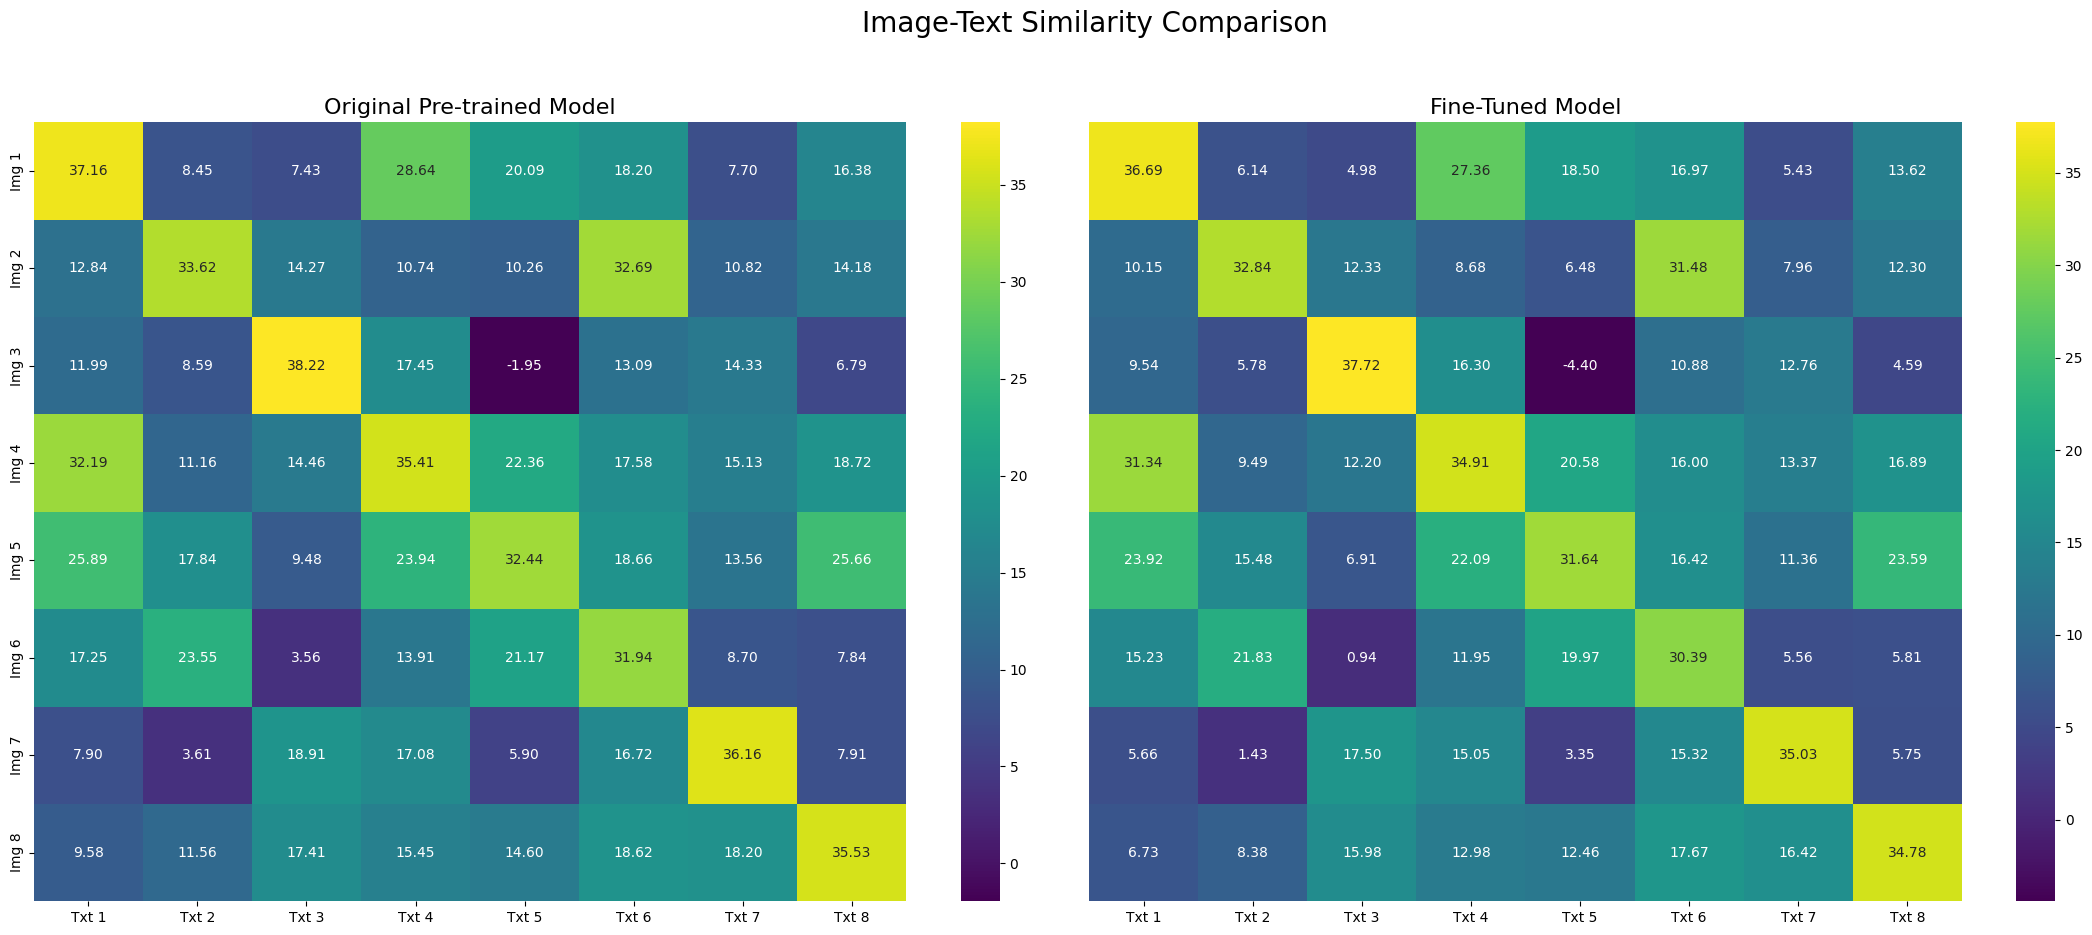

/tmp/ipykernel_116642/1709233668.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/tmp/ipykernel_116642/1709233668.py:267: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_116642/1709233668.py:267: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/public/home/jijh/micromamba/envs/gigapath/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/public/home/jijh/micromamba/envs/gigapath/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


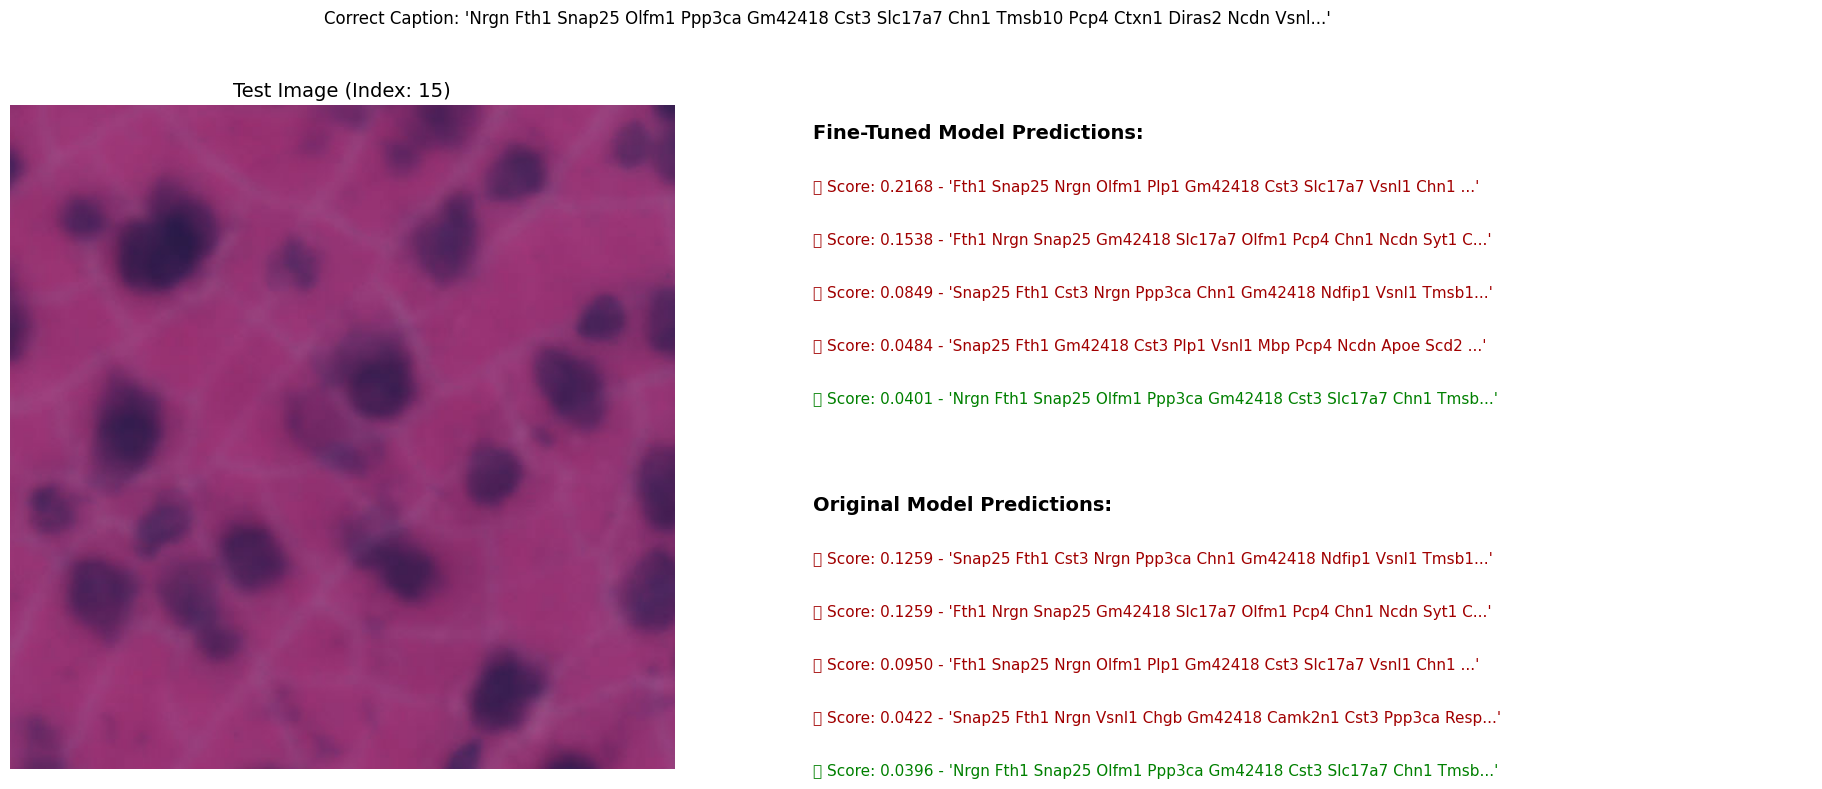

In [18]:
config.PRETRAINED_MODEL_PATH = config.FINETUNED_CHECKPOINT_PATH
config.FINETUNED_CHECKPOINT_PATH = "/cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429/2025_06_20-22_03_22-model_ViT-B-32-lr_1e-06-b_128-j_8-p_amp_bfloat16/checkpoints/epoch_20.pt"
visualizer = ClipVisualizer(config)
visualizer.run_all_visualizations()
# ==============================================================================
# 4. END OF SCRIPT
# ==============================================================================
# This script is designed to visualize the performance of OpenCLIP models.  

## Cell type annotation

In [21]:
# ==============================================================================
#           生物学意义验证脚本：零样本细胞类型注释
# ==============================================================================
import os
import sys
import logging
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import open_clip
from collections import OrderedDict
from sklearn.metrics import classification_report, confusion_matrix

# 尝试导入 safetensors
try:
    from safetensors.torch import load_file as load_safetensors
except ImportError:
    print("错误: 未安装 'safetensors' 库。请使用 'pip install safetensors' 安装。")
    sys.exit(1)

# ==============================================================================
# 1. 配置区域：请根据您的实际情况修改此部分
# ==============================================================================
class ValidationConfig:
    """可视化和验证的所有路径与设置的中心。"""
    # --- 路径设置 ---
    PROJECT_ROOT = "/cwStorage/nodecw_group/jijh/openclip_train"

    # 包含真实标签的验证集清单文件
    # **重要**: 请确保这个 CSV 文件中有一列代表真实的生物学标签，例如 'label'
    ANNOTATED_VAL_MANIFEST = os.path.join(PROJECT_ROOT, "validation_manifest.csv")

    # 您微调后的最终模型检查点路径
    FINETUNED_CHECKPOINT_PATH = os.path.join(
        PROJECT_ROOT,
        "train_log/finetune_20250620-204429/2025_06_20-20_44_44-model_ViT-B-32-lr_5e-06-b_512-j_8-p_amp_bfloat16/checkpoints/epoch_10.pt"  # 这里使用您提供的第二次训练的 checkpoint
    )

    # --- 模型与设备 ---
    MODEL_NAME = "ViT-B-32"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # --- CSV 标签列 ---
    # **重要**: 请将 'label' 替换为您CSV文件中实际的标签列名
    LABEL_COLUMN = "label"

# ==============================================================================
# 2. 核心生物学输入：定义标志性基因（Marker Genes）
# ==============================================================================
# 这是这个任务的核心生物学输入。
# 您需要根据您研究的细胞类型，定义它们的标志性基因。
# 作为一个具体的例子，我为您的小鼠大脑数据定义了三种主要细胞类型的标志性基因。
# 您可以根据您的实际需要修改或扩展这个字典。
MARKER_GENE_SENTENCES = {
    "Neuron": "Snap25 Rbfox3 Syn1 Grin1 Camk2a Tbr1",
    "Astrocyte": "Gfap Aqp4 Aldh1l1 Slc1a2 Slc1a3 Sox9",
    "Oligodendrocyte": "Mbp Mog Plp1 Cnp Sox10 Olig1 Olig2",
    "Microglia": "Aif1 (Iba1) Tmem119 P2ry12 Cx3cr1 Csf1r",
    # 您可以继续添加更多细胞类型，例如 "Endothelial", "Pericyte" 等
}

# ==============================================================================
# 3. 验证器类
# ==============================================================================
class BiologicalValidator:
    """
    一个用于执行生物学意义验证任务的类。
    """
    def __init__(self, config: ValidationConfig):
        """
        初始化验证器，加载模型和数据。
        """
        self.config = config
        self._setup_logging()

        logging.info("初始化 BiologicalValidator...")
        logging.info(f"使用设备: {self.config.DEVICE.upper()}")

        self.model, self.img_processor, self.tokenizer = self._load_model(
            "Fine-tuned", self.config.FINETUNED_CHECKPOINT_PATH
        )
        self.df_val_annotated = self._load_annotated_data()
        self.class_names = list(MARKER_GENE_SENTENCES.keys())

    def _setup_logging(self):
        """配置日志格式和级别。"""
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s - [%(levelname)s] - %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S"
        )

    def _load_model(self, model_id: str, checkpoint_path: str):
        """
        健壮地从本地文件加载OpenCLIP模型及其预处理器。
        此版本自动处理分布式数据并行（DDP）训练产生的检查点。
        """
        logging.info(f"正在从以下路径加载 {model_id} 模型: {checkpoint_path}")

        if not os.path.exists(checkpoint_path):
            logging.error(f"检查点文件未找到: {checkpoint_path}")
            raise FileNotFoundError(f"检查点文件未找到: {checkpoint_path}")

        # 创建模型结构
        model, _, image_processor = open_clip.create_model_and_transforms(
            self.config.MODEL_NAME,
            pretrained=None, # 我们将手动加载权重
            device=self.config.DEVICE
        )
        tokenizer = open_clip.get_tokenizer(self.config.MODEL_NAME)

        # 加载权重
        if checkpoint_path.endswith(".safetensors"):
            state_dict = load_safetensors(checkpoint_path, device=self.config.DEVICE)
        else:
            state_dict = torch.load(checkpoint_path, map_location=self.config.DEVICE)

        # 如果检查点来自训练脚本，它可能包含在一个 'state_dict' 键下
        if 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']

        # 检查并移除DDP训练时添加的 'module.' 前缀
        if all(key.startswith('module.') for key in state_dict.keys()):
            logging.info("检测到DDP训练产生的 'module.' 前缀，正在移除...")
            stripped_state_dict = OrderedDict()
            for key, value in state_dict.items():
                new_key = key.replace('module.', '', 1)
                stripped_state_dict[new_key] = value
            state_dict = stripped_state_dict

        try:
            model.load_state_dict(state_dict, strict=True)
            logging.info(f"{model_id} 模型加载成功。")
        except RuntimeError as e:
            logging.error(f"为 {model_id} 加载 state_dict 失败。密钥不匹配错误: {e}")
            raise

        model.eval()
        return model, image_processor, tokenizer

    def _load_annotated_data(self):
        """加载带标注的验证清单CSV文件。"""
        logging.info(f"正在从以下路径加载带标注的验证数据: {self.config.ANNOTATED_VAL_MANIFEST}")
        try:
            df = pd.read_csv(self.config.ANNOTATED_VAL_MANIFEST)
            # **关键检查**: 确保标签列存在
            if self.config.LABEL_COLUMN not in df.columns:
                logging.error(f"错误：在 '{self.config.ANNOTATED_VAL_MANIFEST}' 中未找到指定的标签列 '{self.config.LABEL_COLUMN}'。")
                logging.error(f"可用的列是: {df.columns.tolist()}")
                raise ValueError("标签列未找到。")
            
            # 过滤掉标签不在我们 marker gene 字典中的行
            original_len = len(df)
            df = df[df[self.config.LABEL_COLUMN].isin(self.class_names)]
            logging.info(f"成功加载清单，共 {len(df)} 个样本。 (已根据 MARKER_GENE_SENTENCES 过滤，原数量: {original_len})")
            return df
        except FileNotFoundError:
            logging.error(f"验证清单文件未找到: {self.config.ANNOTATED_VAL_MANIFEST}")
            raise

    def run_zero_shot_classification(self, batch_size=64):
        """
        执行零样本分类任务并报告结果。
        """
        logging.info("开始执行零样本细胞类型注释...")

        # 步骤 1: 将所有标志性基因句子编码为文本特征
        logging.info("正在编码标志性基因句子...")
        marker_sentences = list(MARKER_GENE_SENTENCES.values())
        text_tokens = self.tokenizer(marker_sentences).to(self.config.DEVICE)
        with torch.no_grad(), torch.cuda.amp.autocast():
            text_features = self.model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
        logging.info(f"已成功编码 {len(self.class_names)} 个细胞类型的文本特征。")

        # 步骤 2: 批量处理验证集图像
        y_true = []
        y_pred = []
        
        # 获取图像路径和真实标签
        image_paths = self.df_val_annotated['image_path'].tolist()
        true_labels = self.df_val_annotated[self.config.LABEL_COLUMN].tolist()

        logging.info(f"开始在 {len(image_paths)} 个验证图像上进行推理...")
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = true_labels[i:i+batch_size]
            
            # 预处理图像
            images = [self.img_processor(Image.open(p).convert("RGB")) for p in batch_paths]
            image_tensor = torch.stack(images).to(self.config.DEVICE)

            # 编码图像并计算相似度
            with torch.no_grad(), torch.cuda.amp.autocast():
                image_features = self.model.encode_image(image_tensor)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                
                # 计算图像与所有文本特征的相似度
                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            
            # 获取预测结果
            predictions = similarity.argmax(dim=-1).cpu().numpy()
            
            y_pred.extend([self.class_names[p] for p in predictions])
            y_true.extend(batch_labels)
            
            if i % (batch_size * 5) == 0:
                 logging.info(f"已处理 {i + len(batch_paths)} / {len(image_paths)} 个图像...")
                 
        # 步骤 3: 评估和可视化结果
        self._evaluate_and_plot(y_true, y_pred)

    def _evaluate_and_plot(self, y_true, y_pred):
        """
        计算并打印分类报告，绘制混淆矩阵。
        """
        logging.info("\n" + "="*50 + "\n           零样本分类结果\n" + "="*50)
        
        # 打印分类报告 (Precision, Recall, F1-score)
        report = classification_report(y_true, y_pred, labels=self.class_names)
        print(report)
        
        # 绘制混淆矩阵
        logging.info("正在绘制混淆矩阵...")
        cm = confusion_matrix(y_true, y_pred, labels=self.class_names)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=self.class_names, 
            yticklabels=self.class_names
        )
        plt.title('零样本细胞类型注释 - 混淆矩阵', fontsize=16)
        plt.xlabel('预测标签', fontsize=12)
        plt.ylabel('真实标签', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

# ==============================================================================
# 4. 执行脚本
# ==============================================================================
try:
    config = ValidationConfig()
    validator = BiologicalValidator(config)
    validator.run_zero_shot_classification()

except (FileNotFoundError, RuntimeError, ImportError, ValueError) as e:
    logging.error(f"发生了一个严重错误: {e}")
    logging.error("请检查您的路径、CSV文件内容以及在 ValidationConfig 中的库安装。")
except Exception as e:
    logging.error(f"执行期间发生意外错误: {e}", exc_info=True)

ERROR:root:错误：在 '/cwStorage/nodecw_group/jijh/openclip_train/validation_manifest.csv' 中未找到指定的标签列 'label'。
ERROR:root:可用的列是: ['image_path', 'gene_sentence']
ERROR:root:发生了一个严重错误: 标签列未找到。
ERROR:root:请检查您的路径、CSV文件内容以及在 ValidationConfig 中的库安装。


# 大号人clip训练

In [ ]:
# ==============================================================================
#      OmiCLIP 复现工作流: 从数据到模型训练的完整脚本
# ==============================================================================
# 步骤 1: 创建训练/验证清单文件
# 步骤 2: 启动 OpenCLIP 分布式微调训练
# ==============================================================================

import os
import sys
import subprocess
import shlex
import fcntl
import select
import datetime
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# --- 辅助函数: 清单文件创建 ---
def create_manifest(tiles_basedir, sentences_basedir, output_dir, val_split=0.05):
    """
    扫描切片和句子目录，为OpenClip训练创建CSV清单文件。
    """
    os.makedirs(output_dir, exist_ok=True)
    
    manifest_data = []
    print("--- [步骤 1/3] 开始扫描目录以构建清单文件 ---")

    # 假设句子目录以 '_sentences_hvg' 结尾
    sentence_dirs = [d for d in os.listdir(sentences_basedir) if os.path.isdir(os.path.join(sentences_basedir, d)) and d.endswith('_sentences_hvg')]

    for sent_dir_name in tqdm(sentence_dirs, desc="处理样本"):
        sample_id = sent_dir_name.replace('_sentences_hvg', '')
        tile_dir_name = f"{sample_id}_tiles" # 假设切片目录的后缀是 '_tiles'
        
        sent_dir_path = os.path.join(sentences_basedir, sent_dir_name)
        tile_dir_path = os.path.join(tiles_basedir, tile_dir_name)
        
        if not os.path.isdir(tile_dir_path):
            # print(f"警告: 未找到样本 {sample_id} 对应的切片目录，已跳过。路径: {tile_dir_path}")
            continue
            
        sentence_files = os.listdir(sent_dir_path)
        if not sentence_files:
            continue

        for sentence_file in sentence_files:
            if not sentence_file.endswith('.txt'):
                continue
            
            image_file = sentence_file.replace('.txt', '.png')
            image_path = os.path.join(tile_dir_path, image_file)
            
            if os.path.exists(image_path):
                with open(os.path.join(sent_dir_path, sentence_file), 'r') as f:
                    gene_sentence = f.read().strip()
                
                # 确保句子不为空
                if gene_sentence:
                    manifest_data.append({
                        'image_path': image_path,
                        'gene_sentence': gene_sentence
                    })

    if not manifest_data:
        raise ValueError("未能找到任何匹配的 图像-句子 对。请仔细检查您的目录路径和文件命名规则。")

    df = pd.DataFrame(manifest_data)
    print(f"✅ 成功找到 {len(df)} 个匹配的 图像-句子 对。")

    if val_split > 0:
        train_df, val_df = train_test_split(df, test_size=val_split, random_state=42, shuffle=True)
        val_path = os.path.join(output_dir, 'validation_manifest_allhuman.csv')
        val_df.to_csv(val_path, index=False, sep=',')
        print(f"✅ 验证集清单已保存至: {val_path} ({len(val_df)} 个样本)")
    else:
        train_df = df

    train_path = os.path.join(output_dir, 'train_manifest_allhuman.csv')
    train_df.to_csv(train_path, index=False, sep=',')
    print(f"✅ 训练集清单已保存至: {train_path} ({len(train_df)} 个样本)")
    print("--- [步骤 1/3] 清单文件创建完成 ---\n")


# --- 训练配置类 ---
class OpenClipFinetuneConfig:
    # --- [可修改] 硬件与路径配置 ---
    GPU_IDS = [0, 1, 2]
    PROJECT_ROOT = "/cwStorage/nodecw_group/jijh/openclip_train"
    # 【关键路径】确保这些指向正确的位置
    TILES_BASEDIR = '/cwStorage/nodecw_group/jijh/hest_output'
    # 【关键路径】使用我们新生成的、干净的句子数据
    SENTENCES_BASEDIR = '/cwStorage/nodecw_group/jijh/hest_sentences_human_all'
    OPEN_CLIP_SRC_DIR = os.path.join(PROJECT_ROOT, "open_clip/src")
    PRETRAINED_MODEL_PATH = os.path.join(PROJECT_ROOT, "open_clip/CLIP-ViT-B-32/open_clip_model.safetensors")

    # --- [可修改] 训练超参数 ---
    EPOCHS = 30
    BATCH_SIZE_PER_GPU = 512
    LEARNING_RATE = 5e-6
    WARMUP_STEPS = 1500
    PRECISION = "amp_bfloat16" # 适用于 H100/A100 GPU
    NUM_WORKERS = 8

    # --- [通常无需修改] 内部参数 ---
    NUM_GPUS = len(GPU_IDS)
    DDP_MASTER_PORT = 29501 # 如果端口冲突可以修改
    TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    LOGS_DIR = os.path.join(PROJECT_ROOT, "train_log", f"finetune_{TIMESTAMP}")
    TRAIN_MANIFEST = os.path.join(PROJECT_ROOT, "train_manifest_allhuman.csv")
    VAL_MANIFEST = os.path.join(PROJECT_ROOT, "validation_manifest_allhuman.csv")
    
    MODEL_NAME = "ViT-B-32"
    DATASET_TYPE = "csv"
    CSV_SEPARATOR = ","
    CSV_IMG_KEY = "image_path"
    CSV_CAPTION_KEY = "gene_sentence"
    FORCE_CONTEXT_LENGTH = 77
    REPORT_TO = "tensorboard"
    SAVE_FREQUENCY = 10
    LOG_EVERY_N_STEPS = 100

    def build_command(self):
        """构建最终的 torchrun 命令"""
        cmd = [
            sys.executable, "-m", "torch.distributed.run",
            f"--nproc_per_node={self.NUM_GPUS}", f"--master_port={self.DDP_MASTER_PORT}",
            os.path.join(self.OPEN_CLIP_SRC_DIR, "training/main.py"), # 注意：新版open_clip的路径可能是 training/main.py
            "--model", self.MODEL_NAME, "--pretrained", self.PRETRAINED_MODEL_PATH,
            "--train-data", self.TRAIN_MANIFEST, "--val-data", self.VAL_MANIFEST,
            "--dataset-type", self.DATASET_TYPE, "--csv-separator", self.CSV_SEPARATOR,
            "--csv-img-key", self.CSV_IMG_KEY, "--csv-caption-key", self.CSV_CAPTION_KEY,
            "--logs", self.LOGS_DIR, "--epochs", str(self.EPOCHS),
            "--batch-size", str(self.BATCH_SIZE_PER_GPU), "--lr", str(self.LEARNING_RATE),
            "--wd", str(self.WEIGHT_DECAY), "--warmup", str(self.WARMUP_STEPS),
            "--precision", self.PRECISION, "--force-context-length", str(self.FORCE_CONTEXT_LENGTH),
            "--workers", str(self.NUM_WORKERS), "--report-to", self.REPORT_TO,
            "--save-frequency", str(self.SAVE_FREQUENCY), "--log-every-n-steps", str(self.LOG_EVERY_N_STEPS),
        ]
        return cmd



In [2]:
# --- 主执行流程 ---

# 1. 实例化配置
config = OpenClipFinetuneConfig()

# 2. 准备清单文件
# 如果清单文件不存在，则自动创建
if not os.path.exists(config.TRAIN_MANIFEST) or not os.path.exists(config.VAL_MANIFEST):
    create_manifest(
        tiles_basedir=config.TILES_BASEDIR,
        sentences_basedir=config.SENTENCES_BASEDIR,
        output_dir=config.PROJECT_ROOT, # 清单文件保存在项目根目录
        val_split=0.05
    )
else:
    print("--- [步骤 1/3] 检测到已存在的清单文件，将跳过创建步骤。 ---\n")

# 3. 检查所有关键路径
print("--- [步骤 2/3] 开始检查关键文件和目录 ---")
os.makedirs(config.LOGS_DIR, exist_ok=True)
paths_to_check = {
    "训练脚本": os.path.join(config.OPEN_CLIP_SRC_DIR, "training/main.py"), # 再次检查新路径
    "训练清单": config.TRAIN_MANIFEST,
    "验证清单": config.VAL_MANIFEST,
    "预训练模型": config.PRETRAINED_MODEL_PATH,
}
all_paths_ok = True
for name, path in paths_to_check.items():
    if not os.path.exists(path):
        print(f"❌ 错误: {name} 未找到，路径: {path}")
        # 尝试检查旧版 open_clip 的路径
        if name == "训练脚本":
            old_path = os.path.join(config.OPEN_CLIP_SRC_DIR, "open_clip_train/main.py")
            if os.path.exists(old_path):
                print(f"ℹ️ 提示: 在旧路径找到了训练脚本: {old_path}。将使用此路径。")
                paths_to_check[name] = old_path # 动态修正路径
            else:
                all_paths_ok = False
        else:
            all_paths_ok = False

if not all_paths_ok:
    print("\n请修正上述路径错误后再运行此脚本。")
    sys.exit(1) # 发现错误则退出
    
print("✅ 所有关键文件和目录均已找到。")
print(f"✅ 日志和模型将保存到: {config.LOGS_DIR}")



--- [步骤 1/3] 检测到已存在的清单文件，将跳过创建步骤。 ---

--- [步骤 2/3] 开始检查关键文件和目录 ---
❌ 错误: 训练脚本 未找到，路径: /cwStorage/nodecw_group/jijh/openclip_train/open_clip/src/training/main.py
ℹ️ 提示: 在旧路径找到了训练脚本: /cwStorage/nodecw_group/jijh/openclip_train/open_clip/src/open_clip_train/main.py。将使用此路径。
✅ 所有关键文件和目录均已找到。
✅ 日志和模型将保存到: /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250622-050651


In [3]:
# 4. 构建并执行训练命令
print("\n--- [步骤 3/3] 构建并准备执行训练命令 ---")
config.OPEN_CLIP_SRC_DIR_FINAL = os.path.dirname(paths_to_check["训练脚本"]) # 使用实际找到的路径
command_list = config.build_command()

execution_env = os.environ.copy()
execution_env["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, config.GPU_IDS))

print("\n" + "="*80)
print("      即将执行以下命令:")
print("="*80)
print(shlex.join(command_list))
print("="*80, "\n")

try:
    process = subprocess.Popen(
        command_list, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True,
        encoding='utf-8', errors='replace', env=execution_env, bufsize=1
    )
    print("--- [ 训练开始，实时日志如下 ] ---\n")
    with process.stdout:
        for line in iter(process.stdout.readline, ""):
            sys.stdout.write(line)
    exit_code = process.wait()
    
    print(f"\n--- [ 训练结束，退出码: {exit_code} ] ---")
    if exit_code == 0:
        print("✅ 微调任务成功完成！")
    else:
        print("❌ 微调任务失败。请检查上面的日志输出以获取详细错误信息。")

except Exception as e:
    print(f"❌ 执行过程中发生意外错误: {e}")


--- [步骤 3/3] 构建并准备执行训练命令 ---


AttributeError: 'OpenClipFinetuneConfig' object has no attribute 'WEIGHT_DECAY'

In [4]:
# ==============================================================================
#           Cell: OpenCLIP Fine-tuning Launcher (with Resume Logic)
# ==============================================================================
import os
import sys
import subprocess
import shlex
import fcntl
import select
import datetime

# --- 1. Training Configuration ---
class OpenClipFinetuneConfig:
    # --- Hardware & Distributed Training ---
    GPU_IDS = [0, 1, 2]
    NUM_GPUS = len(GPU_IDS)
    DDP_MASTER_PORT = 29501 

    # --- Paths ---
    PROJECT_ROOT = "/cwStorage/nodecw_group/jijh/openclip_train"
    OPEN_CLIP_SRC_DIR = os.path.join(PROJECT_ROOT, "open_clip/src")
    TRAIN_MANIFEST = os.path.join(PROJECT_ROOT, "train_manifest_allhuman.csv")
    VAL_MANIFEST = os.path.join(PROJECT_ROOT, "validation_manifest_allhuman.csv")
    
    # [修改点 1] 指向您之前训练的日志目录，而不是创建一个新的
    # 您需要从之前的日志输出中找到这个确切的目录名
    LOGS_DIR = os.path.join(PROJECT_ROOT, "train_log/finetune_20250620-204429")
    
    # [修改点 2] 定义要恢复的检查点路径
    # 使用 'epoch_latest.pt' 是最安全的选择
    RESUME_CHECKPOINT_PATH = os.path.join(
        LOGS_DIR, 
        "2025_06_20-20_44_44-model_ViT-B-32-lr_5e-06-b_512-j_8-p_amp_bfloat16/checkpoints/epoch_10.pt"
    )
    
    # 预训练模型路径现在不再需要，因为所有信息都在检查点里
    # PRETRAINED_MODEL_PATH = ...

    # --- Model & Data ---
    MODEL_NAME = "ViT-B-32"
    # ... 其他数据参数保持不变 ...
    CSV_IMG_KEY = "image_path"
    CSV_CAPTION_KEY = "gene_sentence"

    # --- Training Hyperparameters ---
    # [修改点 3] 增加总的epochs数量，例如，再训练10个epoch
    TOTAL_EPOCHS = 30  # 原来训练了10个，现在总共训练到20个
    
    # [修改点 4] 恢复训练时，通常使用一个更小的学习率
    LEARNING_RATE = 1e-6 # 从 5e-6 降低到 1e-6 进行更精细的微调
    
    BATCH_SIZE_PER_GPU = 128
    WEIGHT_DECAY = 0.1
    WARMUP_STEPS = 500 # 对于恢复训练，可以将warmup设为0，或者保持不变
    PRECISION = "amp_bfloat16"
    NUM_WORKERS = 8

    # --- Logging & Saving ---
    REPORT_TO = "tensorboard"
    SAVE_FREQUENCY = 10
    LOG_EVERY_N_STEPS = 100

    @classmethod
    def build_command(cls):
        """动态构建torchrun命令列表，现在加入了--resume参数"""
        python_executable = sys.executable
        
        cmd = [
            python_executable, "-m", "torch.distributed.run",
            f"--nproc_per_node={cls.NUM_GPUS}",
            f"--master_port={cls.DDP_MASTER_PORT}",
            os.path.join(cls.OPEN_CLIP_SRC_DIR, "open_clip_train/main.py"),
            
            # [修改点 5] 加入 --resume 参数
            "--resume", cls.RESUME_CHECKPOINT_PATH,
            
            # 模型和数据参数 (注意：--model 仍然需要，但 --pretrained 不再需要)
            "--model", cls.MODEL_NAME,
            "--train-data", cls.TRAIN_MANIFEST,
            "--val-data", cls.VAL_MANIFEST,
            "--dataset-type", "csv",
            "--csv-separator", ",",
            "--csv-img-key", cls.CSV_IMG_KEY,
            "--csv-caption-key", cls.CSV_CAPTION_KEY,
            
            # 日志目录
            "--logs", cls.LOGS_DIR,
            
            # 训练超参数
            "--epochs", str(cls.TOTAL_EPOCHS), # 传递总的epoch数
            "--batch-size", str(cls.BATCH_SIZE_PER_GPU),
            "--lr", str(cls.LEARNING_RATE),
            "--wd", str(cls.WEIGHT_DECAY),
            "--warmup", str(cls.WARMUP_STEPS),
            "--precision", cls.PRECISION,
            
            # 系统和日志参数
            "--workers", str(cls.NUM_WORKERS),
            "--report-to", cls.REPORT_TO,
            "--save-frequency", str(cls.SAVE_FREQUENCY),
            "--log-every-n-steps", str(cls.LOG_EVERY_N_STEPS),
        ]
        return cmd

# --- 实例化配置并执行 ---
config = OpenClipFinetuneConfig()
# 日志目录现在应该已经存在了，所以不需要再创建
# os.makedirs(config.LOGS_DIR, exist_ok=True) 

# --- 检查关键文件 ---
# 现在最关键的是检查检查点文件是否存在
if os.path.exists(config.RESUME_CHECKPOINT_PATH):
    print(f"✅ 找到要恢复的检查点文件: {config.RESUME_CHECKPOINT_PATH}")
    
    # ... (后面接上与之前相同的启动和实时输出代码) ...
    command_list = config.build_command()
    execution_env = os.environ.copy()
    execution_env["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, config.GPU_IDS))

    print("\n" + "="*80)
    print("      即将从检查点恢复训练:")
    print("="*80)
    print(shlex.join(command_list))
    print("="*80, "\n")

    # 执行并实时输出... (代码与上一回答中的相同)
    try:
        process = subprocess.Popen(
            command_list,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            encoding='utf-8',
            errors='replace',
            env=execution_env,
            cwd=config.OPEN_CLIP_SRC_DIR,
            bufsize=1
        )
        # ... (非阻塞读取循环) ...
        # ... (与上一回答中的代码完全相同) ...
        # 设置为非阻塞读取
        fd = process.stdout.fileno()
        fl = fcntl.fcntl(fd, fcntl.F_GETFL)
        fcntl.fcntl(fd, fcntl.F_SETFL, fl | os.O_NONBLOCK)

        print("--- [ 恢复训练开始，实时日志如下 ] ---\n")
        
        while True:
            if process.poll() is not None: break
            readable, _, _ = select.select([process.stdout], [], [], 0.1)
            if process.stdout in readable:
                try:
                    line = process.stdout.read()
                    if line:
                        sys.stdout.write(line)
                        sys.stdout.flush()
                except (TypeError, ValueError):
                    break
        
        remaining_output, _ = process.communicate()
        if remaining_output: print(remaining_output.strip())

        exit_code = process.returncode
        print(f"\n--- [ 训练结束，退出码: {exit_code} ] ---")
        if exit_code == 0:
            print("✅ 恢复训练任务成功完成！")
        else:
            print("❌ 恢复训练任务失败。")

    except Exception as e:
        print(f"❌ 执行过程中发生意外错误: {e}")

else:
    print(f"❌ 错误: 检查点文件未找到！路径: {config.RESUME_CHECKPOINT_PATH}")
    print("   请确认路径是否正确，或者您是否想要从头开始训练。")

✅ 找到要恢复的检查点文件: /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429/2025_06_20-20_44_44-model_ViT-B-32-lr_5e-06-b_512-j_8-p_amp_bfloat16/checkpoints/epoch_10.pt

      即将从检查点恢复训练:
/public/home/jijh/micromamba/envs/gigapath/bin/python -m torch.distributed.run --nproc_per_node=3 --master_port=29501 /cwStorage/nodecw_group/jijh/openclip_train/open_clip/src/open_clip_train/main.py --resume /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429/2025_06_20-20_44_44-model_ViT-B-32-lr_5e-06-b_512-j_8-p_amp_bfloat16/checkpoints/epoch_10.pt --model ViT-B-32 --train-data /cwStorage/nodecw_group/jijh/openclip_train/train_manifest_allhuman.csv --val-data /cwStorage/nodecw_group/jijh/openclip_train/validation_manifest_allhuman.csv --dataset-type csv --csv-separator , --csv-img-key image_path --csv-caption-key gene_sentence --logs /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429 --epochs 30 --batch-size 128 --lr 1e-06 --w

In [12]:
# ==============================================================================
#      OmiCLIP 复现工作流: 健壮的训练启动器
# ==============================================================================
# - 自动创建清单文件
# - 自动检测并从最新检查点恢复
# - 统一的文件名配置，避免路径错误
# ==============================================================================

import os
import sys
import subprocess
import shlex
import datetime
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import glob

# --- 清单创建函数 (保持不变) ---
def create_manifest(tiles_basedir, sentences_basedir, train_path, val_path, val_split=0.05):
    # ... (此函数与您之前的版本完全相同，此处为简洁省略)
    # ... 您可以从之前的回答中复制过来，或者使用下面的简化版
    os.makedirs(os.path.dirname(train_path), exist_ok=True)
    manifest_data = []
    print("--- 开始扫描目录以构建清单文件 ---")
    sentence_dirs = [d for d in os.listdir(sentences_basedir) if os.path.isdir(os.path.join(sentences_basedir, d)) and d.endswith('_sentences_hvg')]
    for sent_dir_name in tqdm(sentence_dirs, desc="处理样本"):
        sample_id = sent_dir_name.replace('_sentences_hvg', '')
        tile_dir_name = f"{sample_id}_tiles"
        sent_dir_path = os.path.join(sentences_basedir, sent_dir_name)
        tile_dir_path = os.path.join(tiles_basedir, tile_dir_name)
        if not os.path.isdir(tile_dir_path): continue
        for sentence_file in os.listdir(sent_dir_path):
            if not sentence_file.endswith('.txt'): continue
            image_file = sentence_file.replace('.txt', '.png')
            image_path = os.path.join(tile_dir_path, image_file)
            if os.path.exists(image_path):
                with open(os.path.join(sent_dir_path, sentence_file), 'r') as f:
                    gene_sentence = f.read().strip()
                if gene_sentence: manifest_data.append({'image_path': image_path, 'gene_sentence': gene_sentence})
    df = pd.DataFrame(manifest_data)
    print(f"✅ 成功找到 {len(df)} 个匹配的 图像-句子 对。")
    train_df, val_df = train_test_split(df, test_size=val_split, random_state=42)
    val_df.to_csv(val_path, index=False, sep=',')
    print(f"✅ 验证集清单已保存至: {val_path} ({len(val_df)} 个样本)")
    train_df.to_csv(train_path, index=False, sep=',')
    print(f"✅ 训练集清单已保存至: {train_path} ({len(train_df)} 个样本)")
    print("--- 清单文件创建完成 ---\n")

# --- 训练配置类 (已更新) ---
class OpenClipFinetuneConfig:
    # --- [可修改] 核心路径配置 ---
    PROJECT_ROOT = "/cwStorage/nodecw_group/jijh/openclip_train"
    TILES_BASEDIR = '/cwStorage/nodecw_group/jijh/hest_output'
    SENTENCES_BASEDIR = '/cwStorage/nodecw_group/jijh/hest_sentences_human_all'
    
    # 【关键修改】统一清单文件名
    TRAIN_MANIFEST_NAME = "train_manifest_v2.csv"
    VAL_MANIFEST_NAME = "validation_manifest_v2.csv"
    
    # --- [可修改] 训练会话名称 ---
    # 每次开始新的训练（或调整重要参数后），请修改此名称
    # 例如： "finetune_v2_lr_1e-6"
    SESSION_NAME = "finetune_v2_from_epoch10" 

    # --- [可修改] 硬件与超参数 ---
    GPU_IDS = [0, 2]
    EPOCHS = 40           # 总共希望训练到的epoch数
    BATCH_SIZE_PER_GPU = 512  # 每个GPU的批量大小
    LEARNING_RATE = 1e-6  # 从检查点恢复时，使用更小的学习率
    PRECISION = "amp_bfloat16"
    NUM_WORKERS = 16

    # --- [通常无需修改] 内部参数 ---
    NUM_GPUS = len(GPU_IDS)
    DDP_MASTER_PORT = 29501
    LOGS_DIR = os.path.join(PROJECT_ROOT, "train_log", SESSION_NAME)
    TRAIN_MANIFEST_PATH = os.path.join(PROJECT_ROOT, TRAIN_MANIFEST_NAME)
    VAL_MANIFEST_PATH = os.path.join(PROJECT_ROOT, VAL_MANIFEST_NAME)
    
    # 模型相关
    OPEN_CLIP_SRC_DIR = os.path.join(PROJECT_ROOT, "open_clip/src")
    PRETRAINED_MODEL_PATH = os.path.join(PROJECT_ROOT, "open_clip/CLIP-ViT-B-32/open_clip_model.safetensors") # 仅用于从头训练
    MODEL_NAME = "ViT-B-32"
    FORCE_CONTEXT_LENGTH = 77
    WEIGHT_DECAY = 0.1
    WARMUP_STEPS = 500

    # 数据集相关
    DATASET_TYPE = "csv"
    CSV_SEPARATOR = ","
    CSV_IMG_KEY = "image_path"
    CSV_CAPTION_KEY = "gene_sentence"

    # 日志与保存
    REPORT_TO = "tensorboard"
    SAVE_FREQUENCY = 10 # 每5个epoch保存一次
    LOG_EVERY_N_STEPS = 100

    def find_latest_checkpoint(self):
        """自动查找最新的检查点文件"""
        checkpoint_dir = os.path.join(self.LOGS_DIR, "checkpoints")
        if not os.path.isdir(checkpoint_dir):
            return None
        checkpoints = glob.glob(os.path.join(checkpoint_dir, "epoch_*.pt"))
        if not checkpoints:
            return None
        # 按epoch编号排序，找到最大的那个
        latest_checkpoint = max(checkpoints, key=lambda p: int(os.path.basename(p).split('_')[1].split('.')[0]))
        return latest_checkpoint

    def build_command(self, resume_path=None):
        """动态构建torchrun命令"""
        main_script_path = os.path.join(self.OPEN_CLIP_SRC_DIR, "training/main.py")
        if not os.path.exists(main_script_path):
             main_script_path = os.path.join(self.OPEN_CLIP_SRC_DIR, "open_clip_train/main.py") # 兼容旧版

        cmd = [
            sys.executable, "-m", "torch.distributed.run",
            f"--nproc_per_node={self.NUM_GPUS}", f"--master_port={self.DDP_MASTER_PORT}",
            main_script_path
        ]
        
        if resume_path:
            print(f"✅ 找到检查点，将从 {resume_path} 恢复训练。")
            cmd.extend(["--resume", resume_path])
        else:
            print("ℹ️ 未找到检查点，将从头开始训练。")
            cmd.extend(["--model", self.MODEL_NAME, "--pretrained", self.PRETRAINED_MODEL_PATH])

        # 添加通用参数
        cmd.extend([
            "--train-data", self.TRAIN_MANIFEST_PATH, "--val-data", self.VAL_MANIFEST_PATH,
            "--dataset-type", self.DATASET_TYPE, "--csv-separator", self.CSV_SEPARATOR,
            "--csv-img-key", self.CSV_IMG_KEY, "--csv-caption-key", self.CSV_CAPTION_KEY,
            "--logs", self.LOGS_DIR, "--epochs", str(self.EPOCHS),
            "--batch-size", str(self.BATCH_SIZE_PER_GPU), "--lr", str(self.LEARNING_RATE),
            "--wd", str(self.WEIGHT_DECAY), "--warmup", str(self.WARMUP_STEPS),
            "--precision", self.PRECISION, "--force-context-length", str(self.FORCE_CONTEXT_LENGTH),
            "--workers", str(self.NUM_WORKERS), "--report-to", self.REPORT_TO,
            "--save-frequency", str(self.SAVE_FREQUENCY), "--log-every-n-steps", str(self.LOG_EVERY_N_STEPS),
        ])
        return cmd

# --- 主执行流程 ---
if __name__ == "__main__":
    # 1. 实例化配置
    config = OpenClipFinetuneConfig()
    os.makedirs(config.LOGS_DIR, exist_ok=True)
    
    # 2. 准备清单文件
    if not os.path.exists(config.TRAIN_MANIFEST_PATH) or not os.path.exists(config.VAL_MANIFEST_PATH):
        create_manifest(
            tiles_basedir=config.TILES_BASEDIR, sentences_basedir=config.SENTENCES_BASEDIR,
            train_path=config.TRAIN_MANIFEST_PATH, val_path=config.VAL_MANIFEST_PATH, val_split=0.05
        )
    else:
        print(f"✅ 检测到已存在的清单文件，将跳过创建步骤:\n   - {config.TRAIN_MANIFEST_PATH}\n   - {config.VAL_MANIFEST_PATH}")

    # 3. 查找检查点并构建命令
    # 注意：这里的恢复逻辑是基于 LOGS_DIR 的。如果你想从一个完全不同的旧实验中恢复，需要手动指定 `resume_path`。
    # 比如: resume_from = '/path/to/old/experiment/checkpoints/epoch_10.pt'
    resume_from = config.find_latest_checkpoint()
    command_list = config.build_command(resume_path=resume_from)
    
    # 4. 设置环境并执行
    execution_env = os.environ.copy()
    execution_env["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, config.GPU_IDS))
    
    print("\n" + "="*80)
    print("      即将执行以下命令:")
    print("="*80)
    print(shlex.join(command_list))
    print("="*80, "\n")
    
    try:
        process = subprocess.Popen(
            command_list, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True,
            encoding='utf-8', errors='replace', env=execution_env, bufsize=1
        )
        print("--- [ 训练开始，实时日志如下 ] ---\n")
        with process.stdout:
            for line in iter(process.stdout.readline, ""):
                sys.stdout.write(line)
        exit_code = process.wait()
        
        print(f"\n--- [ 训练结束，退出码: {exit_code} ] ---")
        if exit_code == 0:
            print("✅ 训练任务成功完成！")
        else:
            print("❌ 训练任务失败。请检查上面的日志输出。")

    except Exception as e:
        print(f"❌ 执行过程中发生意外错误: {e}")

✅ 检测到已存在的清单文件，将跳过创建步骤:
   - /cwStorage/nodecw_group/jijh/openclip_train/train_manifest_v2.csv
   - /cwStorage/nodecw_group/jijh/openclip_train/validation_manifest_v2.csv
ℹ️ 未找到检查点，将从头开始训练。

      即将执行以下命令:
/public/home/jijh/micromamba/envs/gigapath/bin/python -m torch.distributed.run --nproc_per_node=2 --master_port=29501 /cwStorage/nodecw_group/jijh/openclip_train/open_clip/src/open_clip_train/main.py --model ViT-B-32 --pretrained /cwStorage/nodecw_group/jijh/openclip_train/open_clip/CLIP-ViT-B-32/open_clip_model.safetensors --train-data /cwStorage/nodecw_group/jijh/openclip_train/train_manifest_v2.csv --val-data /cwStorage/nodecw_group/jijh/openclip_train/validation_manifest_v2.csv --dataset-type csv --csv-separator , --csv-img-key image_path --csv-caption-key gene_sentence --logs /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_v2_from_epoch10 --epochs 40 --batch-size 512 --lr 1e-06 --wd 0.1 --warmup 500 --precision amp_bfloat16 --force-context-length 77 --workers 16 -

KeyboardInterrupt: 

In [7]:
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import os

# --- 配置 ---
# 【重要】确保这个路径和您训练脚本中的完全一致
validation_manifest_path = "/cwStorage/nodecw_group/jijh/openclip_train/validation_manifest_v2.csv"
# 清理后的新清单文件名
cleaned_val_manifest_path = "/cwStorage/nodecw_group/jijh/openclip_train/validation_manifest_v2_cleaned.csv"

# --- 开始验证 ---
print(f"开始验证清单文件中的图像: {validation_manifest_path}")

try:
    df = pd.read_csv(validation_manifest_path)
    print(f"总共需要检查 {len(df)} 张图片。")
    
    bad_indices = []
    
    # 使用tqdm来显示进度条
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="验证图像文件"):
        image_path = row['image_path']
        
        # 检查1: 文件是否存在
        if not os.path.exists(image_path):
            print(f"文件不存在: {image_path}")
            bad_indices.append(index)
            continue
            
        # 检查2: 尝试打开并加载图像
        try:
            with Image.open(image_path) as img:
                img.load()  # img.load() 会强制读取所有图像数据，能更好地捕获截断文件错误
        except Exception as e:
            print(f"无法加载图像: {image_path} | 错误: {e}")
            bad_indices.append(index)

    # --- 结果报告与清理 ---
    if bad_indices:
        print(f"\n验证完成！发现 {len(bad_indices)} 个有问题的图像。")
        
        # 从DataFrame中删除这些坏的行
        cleaned_df = df.drop(bad_indices).reset_index(drop=True)
        
        # 保存新的、干净的清单文件
        cleaned_df.to_csv(cleaned_val_manifest_path, index=False)
        
        print(f"已生成一个干净的验证清单文件，保存至: {cleaned_val_manifest_path}")
        print("下一步，请修改您的训练脚本，使用这个新的 '_cleaned.csv' 文件作为验证集。")
        
    else:
        print("\n✅ 恭喜！验证集中的所有图像文件都是有效的。问题可能更复杂，请考虑硬件或网络问题。")

except FileNotFoundError:
    print(f"错误: 清单文件未找到: {validation_manifest_path}")

开始验证清单文件中的图像: /cwStorage/nodecw_group/jijh/openclip_train/validation_manifest_v2.csv
总共需要检查 47443 张图片。


验证图像文件:   0%|          | 0/47443 [00:00<?, ?it/s]


✅ 恭喜！验证集中的所有图像文件都是有效的。问题可能更复杂，请考虑硬件或网络问题。


In [14]:
# ==============================================================================
#      OmiCLIP 复现工作流: 健壮的训练启动器 (已修正)
# ==============================================================================
import os
import sys
import subprocess
import shlex
import datetime
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import glob

# --- 清单创建函数 (保持不变) ---
def create_manifest(tiles_basedir, sentences_basedir, train_path, val_path, val_split=0.05):
    os.makedirs(os.path.dirname(train_path), exist_ok=True)
    manifest_data = []
    print("--- 开始扫描目录以构建清单文件 ---")
    sentence_dirs = [d for d in os.listdir(sentences_basedir) if os.path.isdir(os.path.join(sentences_basedir, d)) and d.endswith('_sentences_hvg')]
    for sent_dir_name in tqdm(sentence_dirs, desc="处理样本"):
        sample_id = sent_dir_name.replace('_sentences_hvg', '')
        tile_dir_name = f"{sample_id}_tiles"
        sent_dir_path = os.path.join(sentences_basedir, sent_dir_name)
        tile_dir_path = os.path.join(tiles_basedir, tile_dir_name)
        if not os.path.isdir(tile_dir_path): continue
        for sentence_file in os.listdir(sent_dir_path):
            if not sentence_file.endswith('.txt'): continue
            image_file = sentence_file.replace('.txt', '.png')
            image_path = os.path.join(tile_dir_path, image_file)
            if os.path.exists(image_path):
                with open(os.path.join(sent_dir_path, sentence_file), 'r') as f:
                    gene_sentence = f.read().strip()
                if gene_sentence: manifest_data.append({'image_path': image_path, 'gene_sentence': gene_sentence})
    if not manifest_data: raise ValueError("未找到任何数据")
    df = pd.DataFrame(manifest_data)
    print(f"✅ 成功找到 {len(df)} 个匹配的 图像-句子 对。")
    train_df, val_df = train_test_split(df, test_size=val_split, random_state=42)
    val_df.to_csv(val_path, index=False, sep=',')
    print(f"✅ 验证集清单已保存至: {val_path} ({len(val_df)} 个样本)")
    train_df.to_csv(train_path, index=False, sep=',')
    print(f"✅ 训练集清单已保存至: {train_path} ({len(train_df)} 个样本)")
    print("--- 清单文件创建完成 ---\n")

# --- 训练配置类 (已修正) ---
class OpenClipFinetuneConfig:
    # --- [可修改] 核心路径配置 ---
    PROJECT_ROOT = "/cwStorage/nodecw_group/jijh/openclip_train"
    TILES_BASEDIR = '/cwStorage/nodecw_group/jijh/hest_output'
    SENTENCES_BASEDIR = '/cwStorage/nodecw_group/jijh/hest_sentences_human_all'
    
    TRAIN_MANIFEST_NAME = "train_manifest_v2.csv"
    VAL_MANIFEST_NAME = "validation_manifest_v2.csv"
    
    # --- [可修改] 训练会话配置 ---
    # 1. 这是你【当前这次新训练】的名称
    SESSION_NAME = "finetune_v3_from_v1_epoch10" 
    
    # 2. 【关键修正】指定要从哪个【旧的训练会话】恢复。如果设为 None，则从头开始。
    #    请确保这个名字是你第一次训练的日志目录名，例如 "finetune_20250620-204429"
    RESUME_FROM_SESSION_NAME = "finetune_20250620-204429"  

    # --- [可修改] 硬件与超参数 (已调整) ---
    GPU_IDS = [1, 2]
    EPOCHS = 40
    BATCH_SIZE_PER_GPU = 256  # 已降低，更安全
    LEARNING_RATE = 1e-6
    PRECISION = "amp_bfloat16"
    NUM_WORKERS = 8  # 已降低，更安全

    # --- [通常无需修改] 内部参数 ---
    NUM_GPUS = len(GPU_IDS)
    DDP_MASTER_PORT = 29501
    LOGS_DIR = os.path.join(PROJECT_ROOT, "train_log", SESSION_NAME)
    TRAIN_MANIFEST_PATH = os.path.join(PROJECT_ROOT, TRAIN_MANIFEST_NAME)
    VAL_MANIFEST_PATH = os.path.join(PROJECT_ROOT, VAL_MANIFEST_NAME)
    
    OPEN_CLIP_SRC_DIR = os.path.join(PROJECT_ROOT, "open_clip/src")
    PRETRAINED_MODEL_PATH = os.path.join(PROJECT_ROOT, "open_clip/CLIP-ViT-B-32/open_clip_model.safetensors")
    MODEL_NAME = "ViT-B-32"
    FORCE_CONTEXT_LENGTH = 77
    WEIGHT_DECAY = 0.1
    WARMUP_STEPS = 500
    DATASET_TYPE = "csv"
    CSV_SEPARATOR = ","
    CSV_IMG_KEY = "image_path"
    CSV_CAPTION_KEY = "gene_sentence"
    REPORT_TO = "tensorboard"
    SAVE_FREQUENCY = 10
    LOG_EVERY_N_STEPS = 100

    def find_latest_checkpoint(self):
        """【关键修正】在指定的【旧会话目录】中查找最新的检查点"""
        if not self.RESUME_FROM_SESSION_NAME:
            return None

        # 在旧的日志目录里找检查点
        resume_log_dir = os.path.join(self.PROJECT_ROOT, "train_log", self.RESUME_FROM_SESSION_NAME)
        
        # OpenCLIP会创建两层目录，需要用通配符找到内部的checkpoints目录
        checkpoint_dirs = glob.glob(os.path.join(resume_log_dir, "*/checkpoints"))
        if not checkpoint_dirs:
            print(f"警告: 在 '{resume_log_dir}' 中未找到 'checkpoints' 子目录。")
            return None
        
        latest_checkpoint = None
        latest_epoch = -1

        for chkpt_dir in checkpoint_dirs:
            checkpoints = glob.glob(os.path.join(chkpt_dir, "epoch_*.pt"))
            if not checkpoints: continue

            for cp in checkpoints:
                try:
                    # 从 'epoch_10.pt' 中提取 10
                    epoch_num = int(os.path.basename(cp).split('_')[1].split('.')[0])
                    if epoch_num > latest_epoch:
                        latest_epoch = epoch_num
                        latest_checkpoint = cp
                except (ValueError, IndexError):
                    continue
        
        return latest_checkpoint

    def build_command(self, resume_path=None):
        """动态构建torchrun命令"""
        main_script_path = os.path.join(self.OPEN_CLIP_SRC_DIR, "training/main.py")
        if not os.path.exists(main_script_path):
             main_script_path = os.path.join(self.OPEN_CLIP_SRC_DIR, "open_clip_train/main.py")

        cmd = [
            sys.executable, "-m", "torch.distributed.run",
            f"--nproc_per_node={self.NUM_GPUS}", f"--master_port={self.DDP_MASTER_PORT}",
            main_script_path
        ]
        
        if resume_path:
            print(f"✅ 找到检查点，将从 {resume_path} 恢复训练。")
            cmd.extend(["--resume", resume_path])
            cmd.extend(["--model", self.MODEL_NAME])  # 恢复时也需要指定模型名
        else:
            print(f"ℹ️ 未找到检查点或未指定恢复会话，将从头开始训练。")
            cmd.extend(["--model", self.MODEL_NAME, "--pretrained", self.PRETRAINED_MODEL_PATH])

        # 添加通用参数
        cmd.extend([
            "--train-data", self.TRAIN_MANIFEST_PATH, "--val-data", self.VAL_MANIFEST_PATH,
            "--dataset-type", self.DATASET_TYPE, "--csv-separator", self.CSV_SEPARATOR,
            "--csv-img-key", self.CSV_IMG_KEY, "--csv-caption-key", self.CSV_CAPTION_KEY,
            "--logs", self.LOGS_DIR, "--epochs", str(self.EPOCHS),
            "--batch-size", str(self.BATCH_SIZE_PER_GPU), "--lr", str(self.LEARNING_RATE),
            "--wd", str(self.WEIGHT_DECAY), "--warmup", str(self.WARMUP_STEPS),
            "--precision", self.PRECISION, "--force-context-length", str(self.FORCE_CONTEXT_LENGTH),
            "--workers", str(self.NUM_WORKERS), "--report-to", self.REPORT_TO,
            "--save-frequency", str(self.SAVE_FREQUENCY), "--log-every-n-steps", str(self.LOG_EVERY_N_STEPS),
        ])
        return cmd

# --- 主执行流程 (已更新) ---
if __name__ == "__main__":
    config = OpenClipFinetuneConfig()
    os.makedirs(config.LOGS_DIR, exist_ok=True)
    
    if not os.path.exists(config.TRAIN_MANIFEST_PATH) or not os.path.exists(config.VAL_MANIFEST_PATH):
        create_manifest(
            tiles_basedir=config.TILES_BASEDIR, sentences_basedir=config.SENTENCES_BASEDIR,
            train_path=config.TRAIN_MANIFEST_PATH, val_path=config.VAL_MANIFEST_PATH, val_split=0.05
        )
    else:
        print(f"✅ 检测到已存在的清单文件，将跳过创建步骤。")

    # 查找检查点并构建命令
    resume_from_path = config.find_latest_checkpoint()
    command_list = config.build_command(resume_path=resume_from_path)
    
    execution_env = os.environ.copy()
    execution_env["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, config.GPU_IDS))
    # [新增] 设置环境变量帮助调试和避免某些网络问题
    execution_env["NCCL_P2P_DISABLE"] = "1"
    execution_env["NCCL_DEBUG"] = "INFO" 
    
    print("\n" + "="*80)
    print("      即将执行以下命令:")
    print("="*80)
    print(shlex.join(command_list))
    print("="*80, "\n")
    
    try:
        process = subprocess.Popen(
            command_list, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True,
            encoding='utf-8', errors='replace', env=execution_env, bufsize=1
        )
        print("--- [ 训练开始，实时日志如下 ] ---\n")
        with process.stdout:
            for line in iter(process.stdout.readline, ""):
                sys.stdout.write(line)
        exit_code = process.wait()
        
        print(f"\n--- [ 训练结束，退出码: {exit_code} ] ---")
        if exit_code == 0:
            print("✅ 训练任务成功完成！")
        else:
            print("❌ 训练任务失败。请检查上面的日志输出。")

    except Exception as e:
        print(f"❌ 执行过程中发生意外错误: {e}")

✅ 检测到已存在的清单文件，将跳过创建步骤。
✅ 找到检查点，将从 /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429/2025_06_20-22_03_22-model_ViT-B-32-lr_1e-06-b_128-j_8-p_amp_bfloat16/checkpoints/epoch_20.pt 恢复训练。

      即将执行以下命令:
/public/home/jijh/micromamba/envs/gigapath/bin/python -m torch.distributed.run --nproc_per_node=2 --master_port=29501 /cwStorage/nodecw_group/jijh/openclip_train/open_clip/src/open_clip_train/main.py --resume /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_20250620-204429/2025_06_20-22_03_22-model_ViT-B-32-lr_1e-06-b_128-j_8-p_amp_bfloat16/checkpoints/epoch_20.pt --model ViT-B-32 --train-data /cwStorage/nodecw_group/jijh/openclip_train/train_manifest_v2.csv --val-data /cwStorage/nodecw_group/jijh/openclip_train/validation_manifest_v2.csv --dataset-type csv --csv-separator , --csv-img-key image_path --csv-caption-key gene_sentence --logs /cwStorage/nodecw_group/jijh/openclip_train/train_log/finetune_v3_from_v1_epoch10 --epochs 40 --batch-size 256 